In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [9]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [10]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [11]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [12]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [13]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [14]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [15]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [16]:
perceptual_ext = PerceptualLoss()

In [17]:
sobel_filter = Sobel().to(device)

In [18]:
def train_a2b_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0
    tf_gen_l = 0
    edge_gen_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
       ############################
        # (1) Update True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())
        
        tf_dis = 0
        for _y_cls, _y_pr_cls in zip(y_cls, y_pr_cls):
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(epoch + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (1.1) Update Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        edge_d_optim.zero_grad()        
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in zip(edge_y_cls, edge_pr_cls):
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(_edge_y_cls.size()[0], dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(epoch + index / iteration)

        edge_dis_l += edge_dis.item()

        
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)

        gen_optim.zero_grad()

        # adversarial loss
        assert y_pr.requires_grad, "ct_pred without gradient"
        assert edge_y_pr.requires_grad, "edge without gradient"
        
        y_pr_cls = tf_discriminator(y_pr)
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(_y_pr_cls.size()[0], dtype=torch.long, device=device)) + tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(_edge_pr_cls.size()[0], dtype=torch.long, device=device)) + edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1), \
                    edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [19]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        total = x.size()[0]
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]
        
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones(total, dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        
        
        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [20]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [21]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [22]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(64, 64, 128, 256, 512), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x[1:])
        return x

# Generator

In [23]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [24]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [25]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [26]:
train_case_path = 'raw/train/*_*'
train_id_case_path = "raw/train_id/*_*"
test_case_path = 'raw/test/*_*'

In [27]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(), identity=False)
trainset_id = Dataset(train_id_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation(), identity=True)

trainset = ConcatDataset([trainset, trainset_id])
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation(), identity=False)

In [28]:
len(trainset), len(testset)

(1344, 191)

In [29]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7ff7c3e48e50>,)

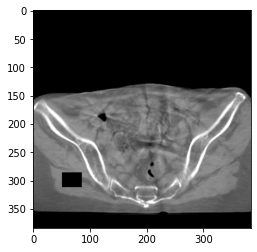

In [30]:
plt.imshow(x.squeeze(), 'gray'),

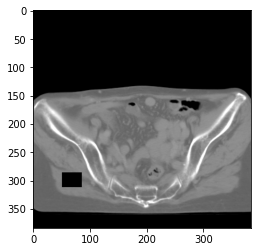

In [31]:
plt.imshow(y.squeeze(), 'gray')

In [32]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [33]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [34]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [35]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [36]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [37]:
edge_discriminator

Discriminator(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.01)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): InstanceNor

In [38]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [39]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=10, T_mult=2)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=10, T_mult=2)

In [40]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [41]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_air, loss_bone, loss_edge_gen, loss_tf_gen, loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_a2b_epoch(epoch, model, gen_optimizer, 
                                                                                             tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                             edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test + score_cont_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test + score_cont_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [01:33,  3.59it/s]
336it [04:11,  1.33it/s]
336it [01:46,  3.15it/s]
48it [00:15,  3.09it/s]
336it [02:04,  2.69it/s]
336it [04:20,  1.29it/s]
336it [01:46,  3.16it/s]
48it [00:14,  3.27it/s]
336it [02:03,  2.73it/s]
336it [04:17,  1.31it/s]
336it [01:46,  3.17it/s]
48it [00:14,  3.27it/s]
336it [02:07,  2.65it/s]
336it [04:16,  1.31it/s]
336it [01:50,  3.04it/s]
48it [00:16,  2.90it/s]
336it [02:10,  2.57it/s]
336it [04:37,  1.21it/s]
336it [01:55,  2.91it/s]
48it [00:15,  3.09it/s]
336it [02:10,  2.57it/s]
336it [04:14,  1.32it/s]
336it [01:58,  2.84it/s]
48it [00:16,  2.86it/s]
336it [02:02,  2.75it/s]
336it [04:15,  1.32it/s]
336it [01:54,  2.94it/s]
48it [00:16,  2.88it/s]
336it [02:06,  2.66it/s]
336it [04:43,  1.18it/s]
336it [01:53,  2.97it/s]
48it [00:17,  2.71it/s]
336it [02:09,  2.59it/s]
336it [04:24,  1.27it/s]
336it [02:00,  2.80it/s]
48it [00:17,  2.78it/s]
336it [02:14,  2.50it/s]
336it [04:31,  1.24it/s]
336it [01:51,  3.00it/s]
48it [00:18,  2.64it/s]
336it [02:

In [42]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [43]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [44]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.8798456788063049
psnr score = 25.518781661987305
snr score = 15.581718444824219
mae error = 0.017415903508663177
air dice score = 0.9982874352867086
bone dice score = 0.9041869217515417
contour dice score = 0.5256869792938232


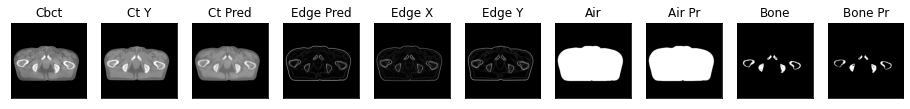

1it [00:01,  1.50s/it]

ssim score = 0.8801577091217041
psnr score = 25.368688583374023
snr score = 15.479162216186523
mae error = 0.0179132129997015
air dice score = 0.9983972625637915
bone dice score = 0.8943115195706811
contour dice score = 0.5173652768135071


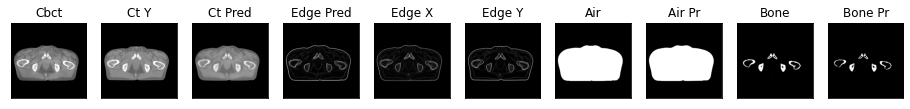

2it [00:02,  1.23s/it]

ssim score = 0.8785006999969482
psnr score = 25.075786590576172
snr score = 15.349154472351074
mae error = 0.01910514011979103
air dice score = 0.9983080524897221
bone dice score = 0.8505557842754143
contour dice score = 0.5335731506347656


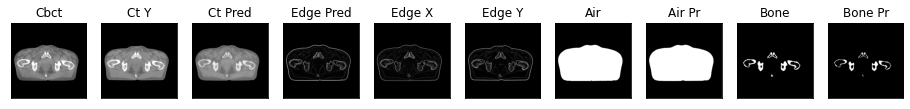

3it [00:02,  1.04s/it]

ssim score = 0.8745352029800415
psnr score = 24.907825469970703
snr score = 15.270448684692383
mae error = 0.01994621753692627
air dice score = 0.9981865846687579
bone dice score = 0.8061302682017097
contour dice score = 0.6066066026687622


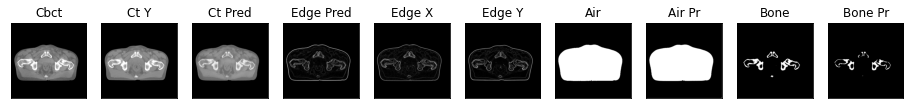

4it [00:03,  1.12it/s]

ssim score = 0.8748227953910828
psnr score = 24.932077407836914
snr score = 15.335000991821289
mae error = 0.020042458549141884
air dice score = 0.9976861923031308
bone dice score = 0.7644402186859467
contour dice score = 0.6261288523674011


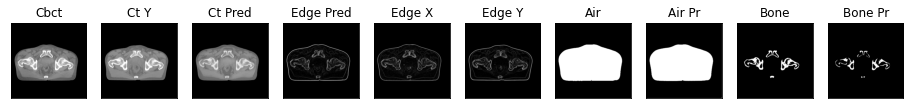

5it [00:03,  1.22it/s]

ssim score = 0.8712103962898254
psnr score = 24.615196228027344
snr score = 15.154657363891602
mae error = 0.02141927368938923
air dice score = 0.9974183298580107
bone dice score = 0.7311184482074791
contour dice score = 0.6481593251228333


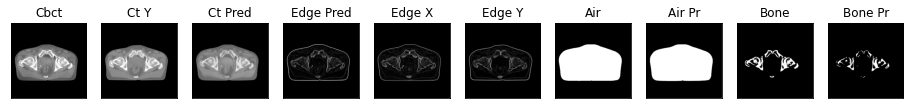

6it [00:04,  1.31it/s]

ssim score = 0.8681849241256714
psnr score = 24.40046501159668
snr score = 14.915867805480957
mae error = 0.021808918565511703
air dice score = 0.9977904640025617
bone dice score = 0.7249551882122589
contour dice score = 0.6525423526763916


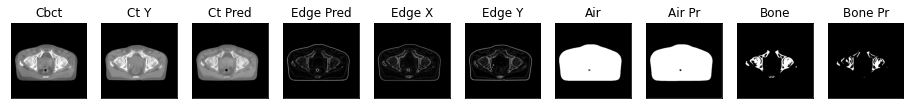

7it [00:05,  1.39it/s]

ssim score = 0.8699027299880981
psnr score = 25.047033309936523
snr score = 15.376900672912598
mae error = 0.019686244428157806
air dice score = 0.997818020934935
bone dice score = 0.7813324886518705
contour dice score = 0.6180934906005859


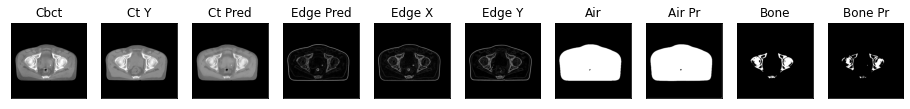

8it [00:05,  1.47it/s]

ssim score = 0.8746078014373779
psnr score = 25.502309799194336
snr score = 15.737621307373047
mae error = 0.018744109198451042
air dice score = 0.9981092203314444
bone dice score = 0.8358471870545431
contour dice score = 0.6191346645355225


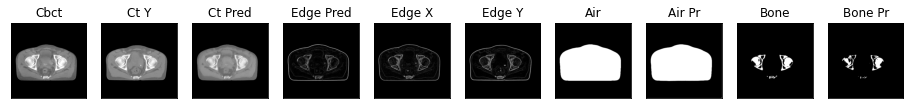

9it [00:06,  1.53it/s]

ssim score = 0.8799242973327637
psnr score = 25.537322998046875
snr score = 15.757351875305176
mae error = 0.018555540591478348
air dice score = 0.9978826499450325
bone dice score = 0.8413461538479698
contour dice score = 0.5308868288993835


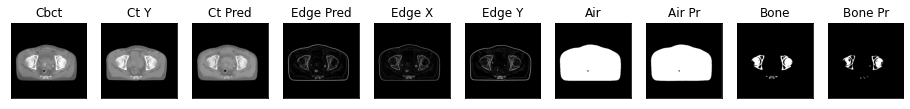

10it [00:06,  1.57it/s]

ssim score = 0.8853533267974854
psnr score = 25.86210060119629
snr score = 16.114397048950195
mae error = 0.018107764422893524
air dice score = 0.9980644566653373
bone dice score = 0.8769902111112513
contour dice score = 0.5321100950241089


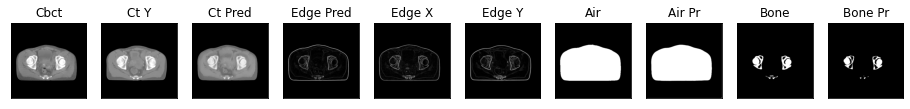

11it [00:08,  1.29it/s]

ssim score = 0.8859808444976807
psnr score = 24.93360137939453
snr score = 15.209607124328613
mae error = 0.019549699500203133
air dice score = 0.9978876739562647
bone dice score = 0.8641532016772692
contour dice score = 0.4889705777168274


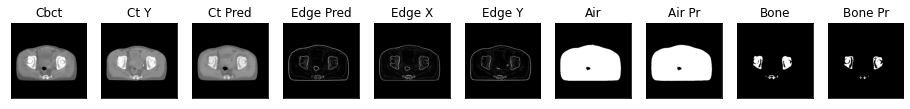

12it [00:08,  1.41it/s]

ssim score = 0.8915247917175293
psnr score = 24.334686279296875
snr score = 14.578770637512207
mae error = 0.020388444885611534
air dice score = 0.9974130978938245
bone dice score = 0.8944083874201896
contour dice score = 0.4751381278038025


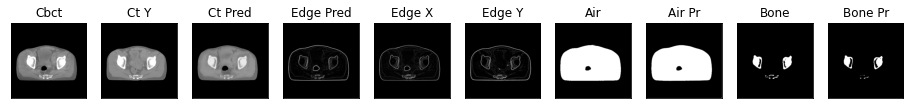

13it [00:09,  1.58it/s]

ssim score = 0.8877429366111755
psnr score = 24.396268844604492
snr score = 14.498396873474121
mae error = 0.01945323497056961
air dice score = 0.9972540819128517
bone dice score = 0.8592510093295385
contour dice score = 0.451453298330307


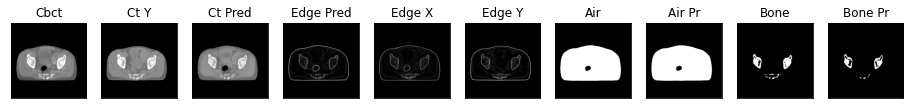

14it [00:09,  1.74it/s]

ssim score = 0.8854114413261414
psnr score = 24.395761489868164
snr score = 14.412227630615234
mae error = 0.01931563764810562
air dice score = 0.996707241943368
bone dice score = 0.8523081490299494
contour dice score = 0.4857849180698395


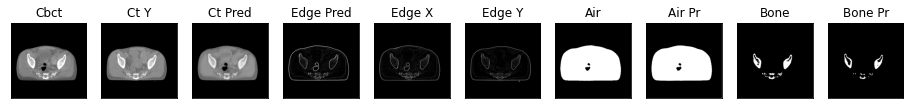

15it [00:09,  1.85it/s]

ssim score = 0.8781080842018127
psnr score = 24.07630729675293
snr score = 14.11625862121582
mae error = 0.020641213282942772
air dice score = 0.9974564497167923
bone dice score = 0.8518308260026706
contour dice score = 0.5347526669502258


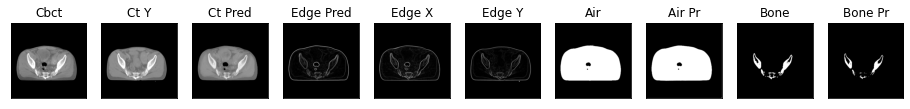

16it [00:10,  1.94it/s]

ssim score = 0.8771145939826965
psnr score = 23.340112686157227
snr score = 13.377521514892578
mae error = 0.02247714251279831
air dice score = 0.9970706186291391
bone dice score = 0.8426616072659892
contour dice score = 0.5302267074584961


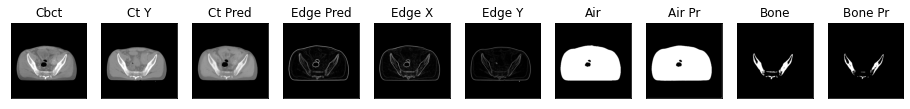

17it [00:10,  2.00it/s]

ssim score = 0.8720596432685852
psnr score = 22.879392623901367
snr score = 12.815037727355957
mae error = 0.02322046272456646
air dice score = 0.9963951760901901
bone dice score = 0.8177765394285625
contour dice score = 0.5136476159095764


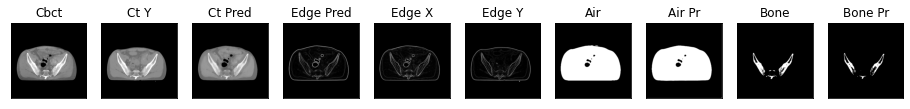

18it [00:11,  2.03it/s]

ssim score = 0.8696559071540833
psnr score = 22.582971572875977
snr score = 12.467935562133789
mae error = 0.02407948486506939
air dice score = 0.9956069364161898
bone dice score = 0.7872640180362459
contour dice score = 0.49169859290122986


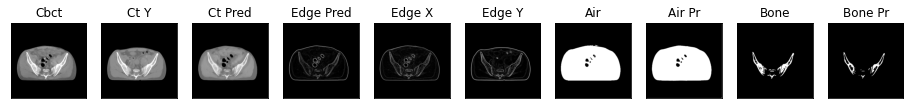

19it [00:11,  2.04it/s]

ssim score = 0.8734968900680542
psnr score = 22.67581558227539
snr score = 12.548469543457031
mae error = 0.024207552894949913
air dice score = 0.9961215398594933
bone dice score = 0.7887077997702459
contour dice score = 0.3733333349227905


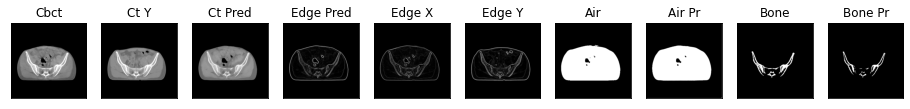

20it [00:12,  1.98it/s]

ssim score = 0.8723620772361755
psnr score = 22.74276351928711
snr score = 12.55057144165039
mae error = 0.023814750835299492
air dice score = 0.9960740450757831
bone dice score = 0.7809069212445361
contour dice score = 0.34938985109329224


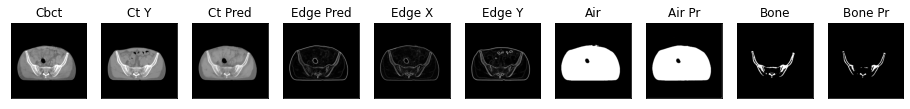

21it [00:13,  1.25it/s]

ssim score = 0.8705000877380371
psnr score = 22.7438907623291
snr score = 12.492269515991211
mae error = 0.02344241552054882
air dice score = 0.9949193975374343
bone dice score = 0.7866645797497783
contour dice score = 0.38009050488471985


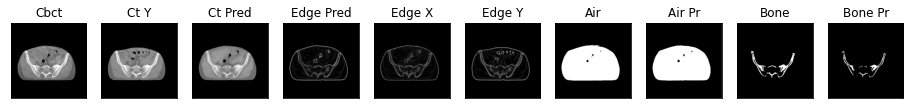

22it [00:14,  1.32it/s]

ssim score = 0.8766762614250183
psnr score = 23.00117301940918
snr score = 12.7161226272583
mae error = 0.022800572216510773
air dice score = 0.9956279175680341
bone dice score = 0.775885054069384
contour dice score = 0.4606375992298126


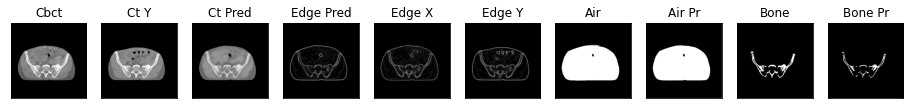

23it [00:15,  1.32it/s]

ssim score = 0.8756875395774841
psnr score = 23.090492248535156
snr score = 12.756879806518555
mae error = 0.022654825821518898
air dice score = 0.9956906953494034
bone dice score = 0.7756382827018166
contour dice score = 0.4193762540817261


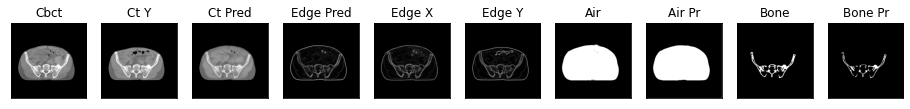

24it [00:15,  1.37it/s]

ssim score = 0.872020959854126
psnr score = 22.886363983154297
snr score = 12.455751419067383
mae error = 0.02267557568848133
air dice score = 0.9953481864922582
bone dice score = 0.7658402203889003
contour dice score = 0.3145161271095276


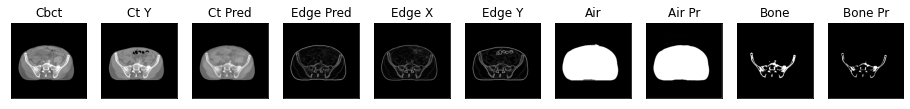

25it [00:16,  1.37it/s]

ssim score = 0.8728567361831665
psnr score = 22.931501388549805
snr score = 12.418153762817383
mae error = 0.022777432575821877
air dice score = 0.9951704647086238
bone dice score = 0.7598072952545105
contour dice score = 0.3964577615261078


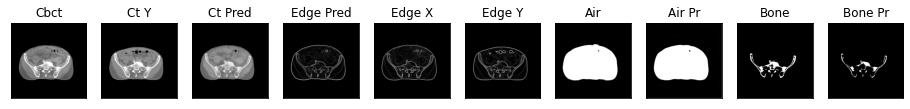

26it [00:17,  1.37it/s]

ssim score = 0.8711408972740173
psnr score = 22.984481811523438
snr score = 12.379947662353516
mae error = 0.02292380854487419
air dice score = 0.9949603155280774
bone dice score = 0.758993778742778
contour dice score = 0.47938504815101624


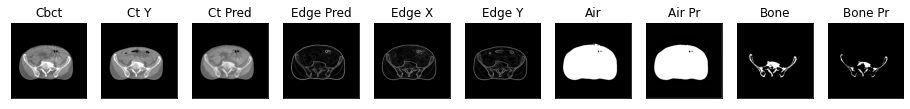

27it [00:17,  1.44it/s]

ssim score = 0.871310293674469
psnr score = 22.88016128540039
snr score = 12.23452091217041
mae error = 0.022816713899374008
air dice score = 0.9943677280699657
bone dice score = 0.7746031746060368
contour dice score = 0.50070720911026


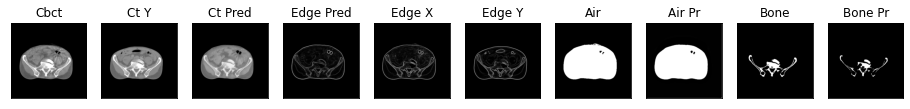

28it [00:18,  1.56it/s]

ssim score = 0.8522694706916809
psnr score = 23.50632095336914
snr score = 14.878477096557617
mae error = 0.024166187271475792
air dice score = 0.9964271339669981
bone dice score = 0.9556313993187827
contour dice score = 0.41844576597213745


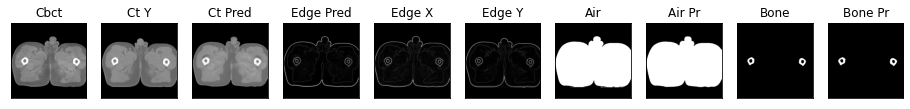

29it [00:19,  1.57it/s]

ssim score = 0.8617907166481018
psnr score = 24.214799880981445
snr score = 15.626214981079102
mae error = 0.022836793214082718
air dice score = 0.9958297559180695
bone dice score = 0.9595342066969568
contour dice score = 0.3668639063835144


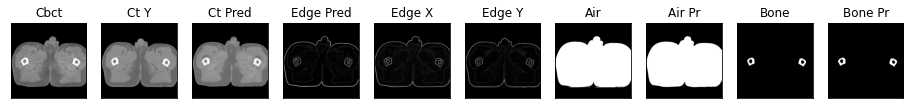

30it [00:19,  1.65it/s]

ssim score = 0.868850827217102
psnr score = 24.979854583740234
snr score = 16.478717803955078
mae error = 0.021166259422898293
air dice score = 0.9960474308300419
bone dice score = 0.9488437281021059
contour dice score = 0.36994218826293945


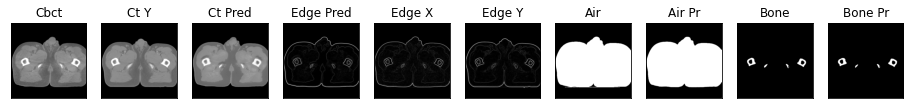

31it [00:20,  1.54it/s]

ssim score = 0.8796058297157288
psnr score = 25.733036041259766
snr score = 17.394458770751953
mae error = 0.01940944790840149
air dice score = 0.9969788153807982
bone dice score = 0.9463032479199233
contour dice score = 0.36924493312835693


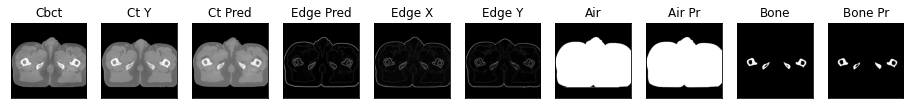

32it [00:20,  1.61it/s]

ssim score = 0.8815805912017822
psnr score = 26.097898483276367
snr score = 17.887460708618164
mae error = 0.018705684691667557
air dice score = 0.9972883071805643
bone dice score = 0.9211365613232656
contour dice score = 0.329772412776947


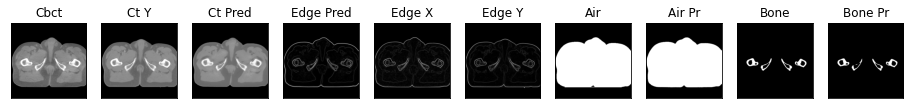

33it [00:21,  1.63it/s]

ssim score = 0.8814488053321838
psnr score = 26.476327896118164
snr score = 18.369129180908203
mae error = 0.018557285889983177
air dice score = 0.9977254313578409
bone dice score = 0.9063467492272143
contour dice score = 0.36422914266586304


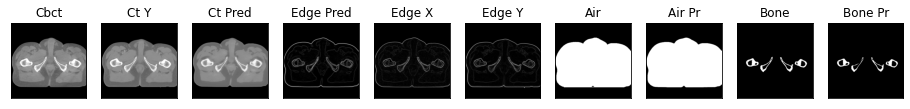

34it [00:22,  1.68it/s]

ssim score = 0.8820521235466003
psnr score = 26.760560989379883
snr score = 18.720462799072266
mae error = 0.019037645310163498
air dice score = 0.9976086566628818
bone dice score = 0.8867788461552069
contour dice score = 0.33100882172584534


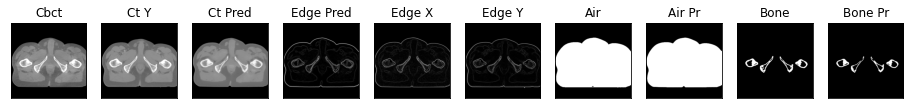

35it [00:22,  1.68it/s]

ssim score = 0.8789709210395813
psnr score = 26.8161678314209
snr score = 18.76618003845215
mae error = 0.019198209047317505
air dice score = 0.9977647837204742
bone dice score = 0.8998306041795614
contour dice score = 0.34214186668395996


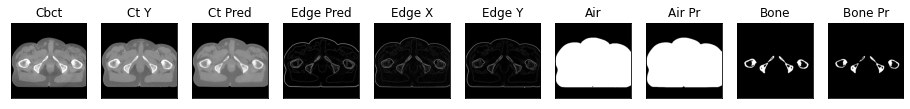

36it [00:23,  1.69it/s]

ssim score = 0.8839950561523438
psnr score = 27.046188354492188
snr score = 18.982540130615234
mae error = 0.01849203370511532
air dice score = 0.9977157813336519
bone dice score = 0.9088480801345703
contour dice score = 0.3225208520889282


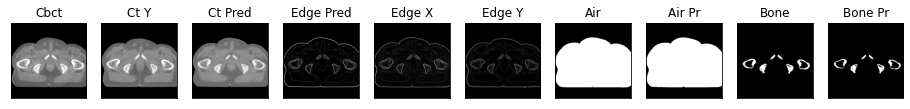

37it [00:23,  1.66it/s]

ssim score = 0.8871565461158752
psnr score = 27.28145980834961
snr score = 19.22981071472168
mae error = 0.01831495203077793
air dice score = 0.9979207756101051
bone dice score = 0.900130008274434
contour dice score = 0.32605665922164917


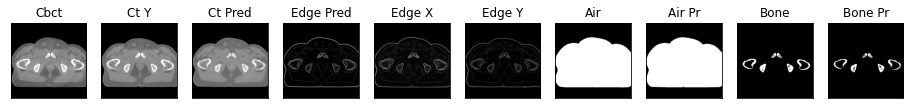

38it [00:24,  1.69it/s]

ssim score = 0.8859228491783142
psnr score = 27.18533706665039
snr score = 19.172771453857422
mae error = 0.018709275871515274
air dice score = 0.9979098628347498
bone dice score = 0.8905234767697618
contour dice score = 0.34855544567108154


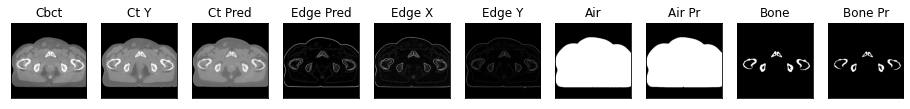

39it [00:25,  1.73it/s]

ssim score = 0.8850128650665283
psnr score = 26.711448669433594
snr score = 18.840171813964844
mae error = 0.02040373906493187
air dice score = 0.9979152931953044
bone dice score = 0.8568024263447053
contour dice score = 0.33831775188446045


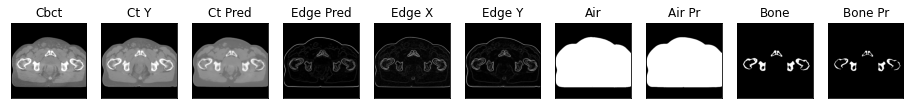

40it [00:25,  1.73it/s]

ssim score = 0.885238528251648
psnr score = 26.508264541625977
snr score = 18.731672286987305
mae error = 0.02195013500750065
air dice score = 0.997871201760125
bone dice score = 0.8185779178657775
contour dice score = 0.3297424018383026


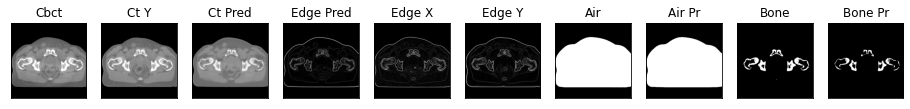

41it [00:26,  1.40it/s]

ssim score = 0.8752009272575378
psnr score = 25.84161376953125
snr score = 18.030977249145508
mae error = 0.023193785920739174
air dice score = 0.9977808003436194
bone dice score = 0.7598343685322808
contour dice score = 0.407320499420166


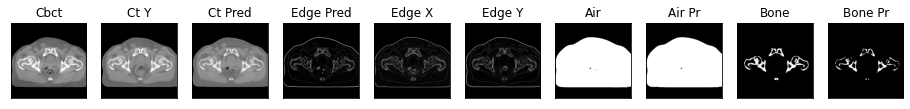

42it [00:27,  1.44it/s]

ssim score = 0.8702561259269714
psnr score = 24.57279396057129
snr score = 16.834346771240234
mae error = 0.025168919935822487
air dice score = 0.9970707228351579
bone dice score = 0.7122719734683891
contour dice score = 0.41902071237564087


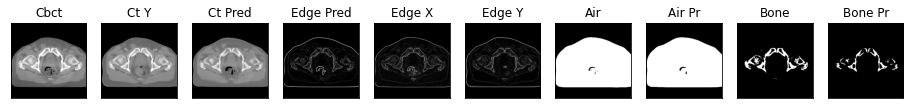

43it [00:27,  1.48it/s]

ssim score = 0.8703959584236145
psnr score = 24.94593620300293
snr score = 17.07139015197754
mae error = 0.023710379377007484
air dice score = 0.9976869977954211
bone dice score = 0.766793539761683
contour dice score = 0.4377358555793762


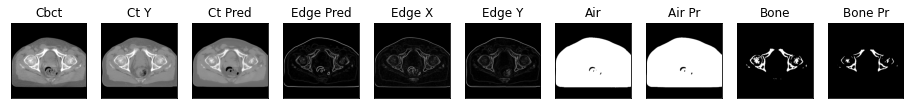

44it [00:28,  1.55it/s]

ssim score = 0.8726001381874084
psnr score = 25.382299423217773
snr score = 17.329195022583008
mae error = 0.02176545187830925
air dice score = 0.9978255091932652
bone dice score = 0.79190228455336
contour dice score = 0.5011842846870422


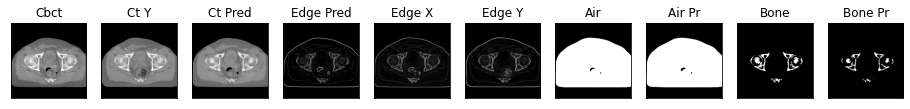

45it [00:29,  1.65it/s]

ssim score = 0.869809627532959
psnr score = 25.51333236694336
snr score = 17.36963653564453
mae error = 0.021921461448073387
air dice score = 0.997985614992349
bone dice score = 0.811962616824773
contour dice score = 0.4888255000114441


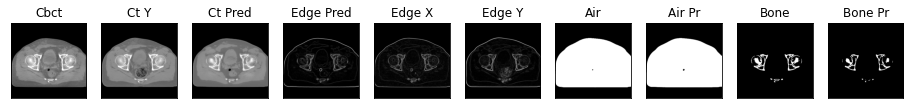

46it [00:29,  1.78it/s]

ssim score = 0.8721099495887756
psnr score = 25.587448120117188
snr score = 17.45944595336914
mae error = 0.02120080403983593
air dice score = 0.9983416252072979
bone dice score = 0.8270866865966073
contour dice score = 0.5090562701225281


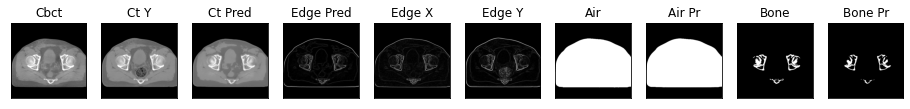

47it [00:29,  1.84it/s]

ssim score = 0.8616323471069336
psnr score = 25.316774368286133
snr score = 17.19880485534668
mae error = 0.0222415030002594
air dice score = 0.9980947495694878
bone dice score = 0.8209753539609755
contour dice score = 0.5021479725837708


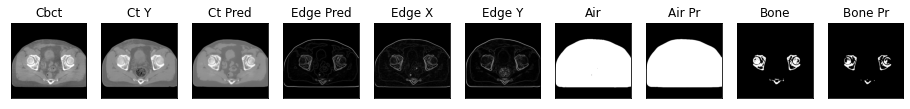

48it [00:30,  1.86it/s]

ssim score = 0.867652177810669
psnr score = 25.34135627746582
snr score = 17.284976959228516
mae error = 0.022343644872307777
air dice score = 0.9980944211268049
bone dice score = 0.8312563840670963
contour dice score = 0.4983293414115906


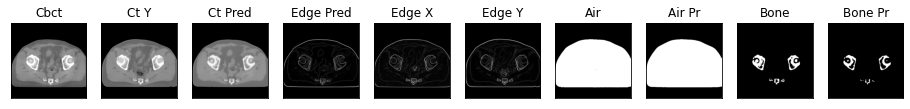

49it [00:30,  1.95it/s]

ssim score = 0.8712982535362244
psnr score = 25.923511505126953
snr score = 17.937213897705078
mae error = 0.021983252838253975
air dice score = 0.9977830591327538
bone dice score = 0.8843394240898849
contour dice score = 0.46095237135887146


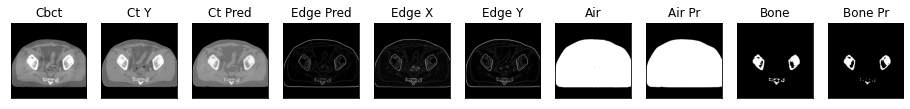

50it [00:31,  1.86it/s]

ssim score = 0.8762935996055603
psnr score = 25.95738410949707
snr score = 17.851980209350586
mae error = 0.02122713066637516
air dice score = 0.9976721188632093
bone dice score = 0.8637637421872842
contour dice score = 0.47238096594810486


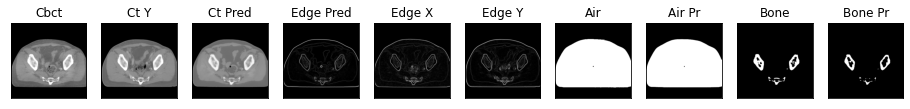

51it [00:34,  1.17s/it]

ssim score = 0.8698410391807556
psnr score = 24.91168785095215
snr score = 16.887910842895508
mae error = 0.02413927949965
air dice score = 0.9972930669367478
bone dice score = 0.8573586330609142
contour dice score = 0.44636014103889465


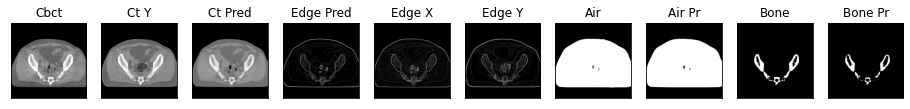

52it [00:35,  1.13s/it]

ssim score = 0.8732242584228516
psnr score = 24.891220092773438
snr score = 16.947589874267578
mae error = 0.02472691237926483
air dice score = 0.9966358438884518
bone dice score = 0.8212513221070601
contour dice score = 0.4219125509262085


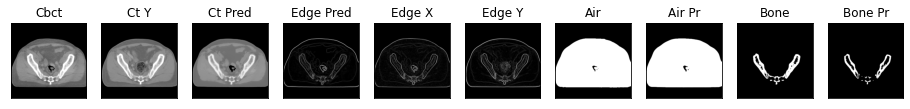

53it [00:36,  1.05s/it]

ssim score = 0.8552085757255554
psnr score = 24.311180114746094
snr score = 16.389108657836914
mae error = 0.026656638830900192
air dice score = 0.9968208551899559
bone dice score = 0.8028822262729595
contour dice score = 0.3818707764148712


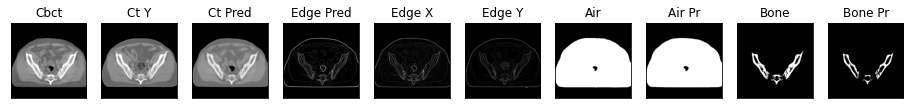

54it [00:36,  1.07it/s]

ssim score = 0.8557772636413574
psnr score = 24.95668601989746
snr score = 17.04715347290039
mae error = 0.025621462613344193
air dice score = 0.9967679928204588
bone dice score = 0.8003709323908247
contour dice score = 0.30510106682777405


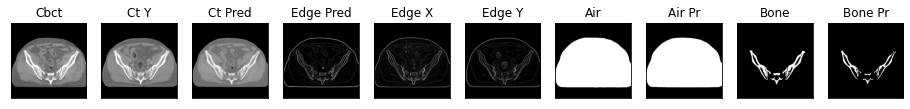

55it [00:37,  1.21it/s]

ssim score = 0.7996695637702942
psnr score = 20.999603271484375
snr score = 10.87981128692627
mae error = 0.032315704971551895
air dice score = 0.997066821200912
bone dice score = 0.9429997373274757
contour dice score = 0.5884955525398254


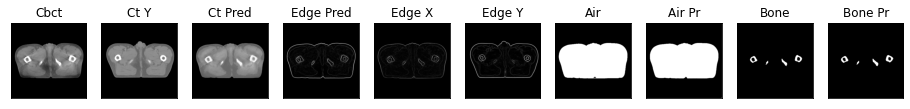

56it [00:37,  1.37it/s]

ssim score = 0.7905381917953491
psnr score = 20.676223754882812
snr score = 10.769413948059082
mae error = 0.03398629650473595
air dice score = 0.9972427366946555
bone dice score = 0.9261062883775967
contour dice score = 0.5627753138542175


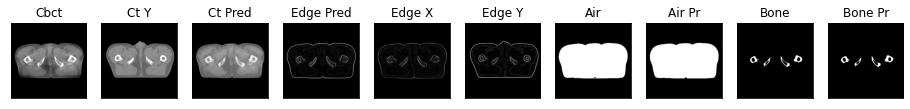

57it [00:38,  1.51it/s]

ssim score = 0.7865766882896423
psnr score = 20.660179138183594
snr score = 10.884505271911621
mae error = 0.034461524337530136
air dice score = 0.9975839873027091
bone dice score = 0.9028892455878232
contour dice score = 0.5734649300575256


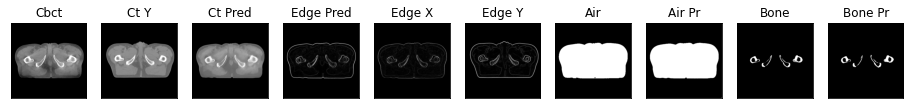

58it [00:38,  1.60it/s]

ssim score = 0.7903962731361389
psnr score = 20.958961486816406
snr score = 11.253690719604492
mae error = 0.033482421189546585
air dice score = 0.9973505983085962
bone dice score = 0.9000381533784808
contour dice score = 0.5380821824073792


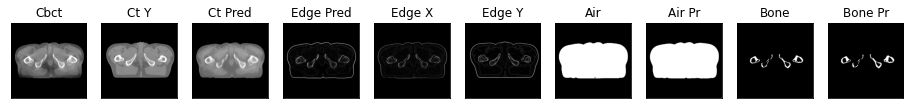

59it [00:39,  1.68it/s]

ssim score = 0.7931848764419556
psnr score = 21.093395233154297
snr score = 11.435689926147461
mae error = 0.03292271867394447
air dice score = 0.9967917617336753
bone dice score = 0.8917716827299523
contour dice score = 0.574700117111206


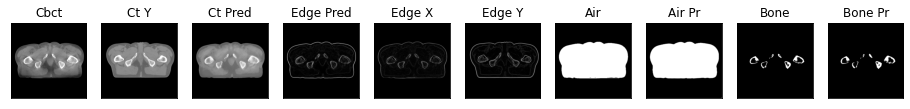

60it [00:39,  1.79it/s]

ssim score = 0.7963078022003174
psnr score = 21.25356674194336
snr score = 11.601478576660156
mae error = 0.0321606807410717
air dice score = 0.9965579441777003
bone dice score = 0.9110621095201936
contour dice score = 0.5480616092681885


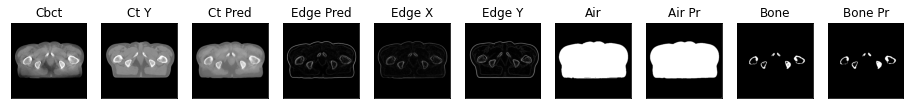

61it [00:40,  1.56it/s]

ssim score = 0.7983981370925903
psnr score = 21.323593139648438
snr score = 11.665002822875977
mae error = 0.031785182654857635
air dice score = 0.9966553440651933
bone dice score = 0.9049671977524842
contour dice score = 0.5617021322250366


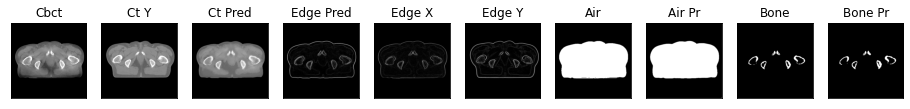

62it [00:41,  1.67it/s]

ssim score = 0.7973304390907288
psnr score = 21.203554153442383
snr score = 11.55907154083252
mae error = 0.032058075070381165
air dice score = 0.9960768011639723
bone dice score = 0.907635009312707
contour dice score = 0.5767392516136169


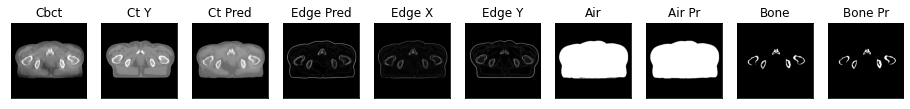

63it [00:41,  1.75it/s]

ssim score = 0.795502245426178
psnr score = 21.15199089050293
snr score = 11.56551742553711
mae error = 0.03239142894744873
air dice score = 0.995672868887931
bone dice score = 0.894306171157615
contour dice score = 0.5723438262939453


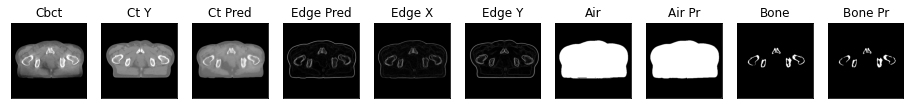

64it [00:42,  1.80it/s]

ssim score = 0.7860689163208008
psnr score = 20.96489143371582
snr score = 11.476978302001953
mae error = 0.0338224358856678
air dice score = 0.9956431338377558
bone dice score = 0.8692192938858078
contour dice score = 0.5596621036529541


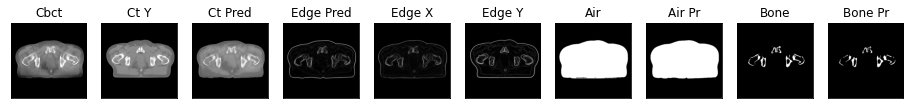

65it [00:42,  1.82it/s]

ssim score = 0.7756115794181824
psnr score = 20.760011672973633
snr score = 11.307924270629883
mae error = 0.035646725445985794
air dice score = 0.9956411625863621
bone dice score = 0.8695238095258806
contour dice score = 0.5365591645240784


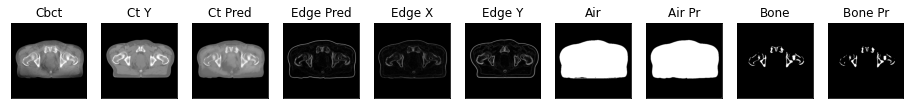

66it [00:43,  1.84it/s]

ssim score = 0.7674873471260071
psnr score = 20.676616668701172
snr score = 11.25723934173584
mae error = 0.036499571055173874
air dice score = 0.9961017838856557
bone dice score = 0.8365482233526244
contour dice score = 0.5931477546691895


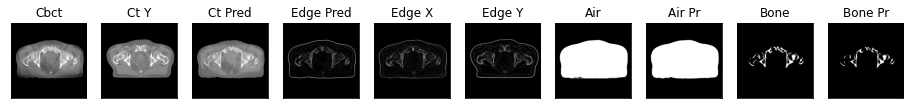

67it [00:43,  1.82it/s]

ssim score = 0.7664873003959656
psnr score = 20.65338897705078
snr score = 11.350826263427734
mae error = 0.036831337958574295
air dice score = 0.9965582515918116
bone dice score = 0.8781971519441698
contour dice score = 0.6202531456947327


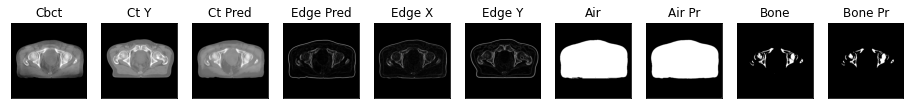

68it [00:44,  1.89it/s]

ssim score = 0.7699857354164124
psnr score = 20.757984161376953
snr score = 11.439436912536621
mae error = 0.036452461034059525
air dice score = 0.9968424403548195
bone dice score = 0.8787969029202085
contour dice score = 0.6666666865348816


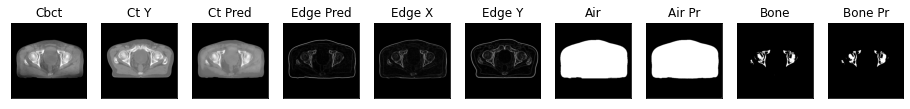

69it [00:44,  1.90it/s]

ssim score = 0.7830495834350586
psnr score = 21.247156143188477
snr score = 11.72944450378418
mae error = 0.033999282866716385
air dice score = 0.9968714546017148
bone dice score = 0.9062451572926353
contour dice score = 0.660580039024353


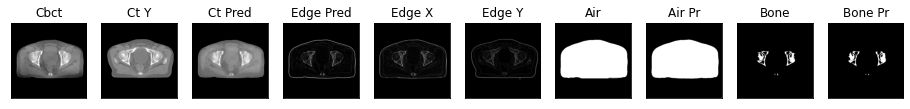

70it [00:45,  1.99it/s]

ssim score = 0.7976321578025818
psnr score = 21.870655059814453
snr score = 12.182550430297852
mae error = 0.031373362988233566
air dice score = 0.9967731415526709
bone dice score = 0.9234518348634826
contour dice score = 0.6286329627037048


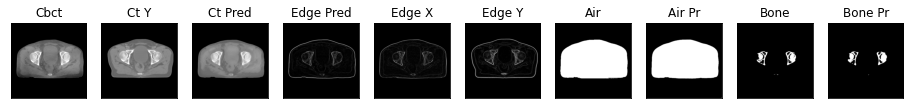

71it [00:46,  1.65it/s]

ssim score = 0.8063006401062012
psnr score = 22.24240493774414
snr score = 12.56846809387207
mae error = 0.02991029992699623
air dice score = 0.9966257878870952
bone dice score = 0.9277092452589507
contour dice score = 0.6068376302719116


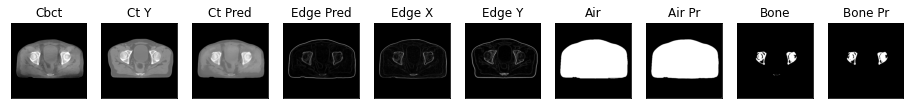

72it [00:46,  1.70it/s]

ssim score = 0.8141745328903198
psnr score = 22.439186096191406
snr score = 12.847079277038574
mae error = 0.029373837634921074
air dice score = 0.9970605827565606
bone dice score = 0.9392310872269639
contour dice score = 0.6308360695838928


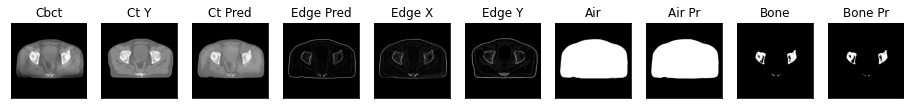

73it [00:47,  1.82it/s]

ssim score = 0.8135889768600464
psnr score = 22.374221801757812
snr score = 12.874289512634277
mae error = 0.030245767906308174
air dice score = 0.9970348658873275
bone dice score = 0.9326096788793515
contour dice score = 0.6203856468200684


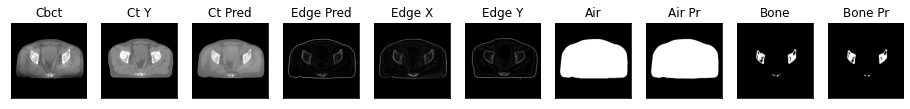

74it [00:47,  1.86it/s]

ssim score = 0.8071908354759216
psnr score = 22.677316665649414
snr score = 13.113954544067383
mae error = 0.02880452387034893
air dice score = 0.9966894163186337
bone dice score = 0.9507544354178287
contour dice score = 0.6287553906440735


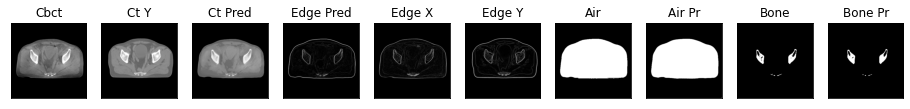

75it [00:48,  1.90it/s]

ssim score = 0.8120266795158386
psnr score = 22.822669982910156
snr score = 13.222914695739746
mae error = 0.027883270755410194
air dice score = 0.9967514016472033
bone dice score = 0.9404825737276054
contour dice score = 0.5878594517707825


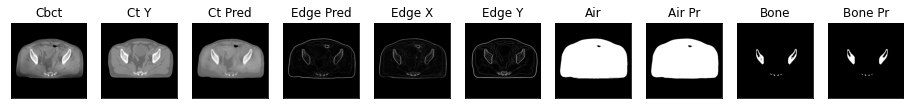

76it [00:48,  1.92it/s]

ssim score = 0.8084316849708557
psnr score = 22.582042694091797
snr score = 13.020033836364746
mae error = 0.029348764568567276
air dice score = 0.9963443906328222
bone dice score = 0.9138780363527454
contour dice score = 0.5920424461364746


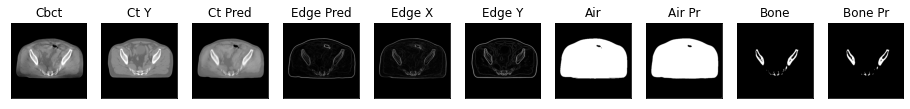

77it [00:49,  1.98it/s]

ssim score = 0.8047243356704712
psnr score = 22.417503356933594
snr score = 12.985997200012207
mae error = 0.030188964679837227
air dice score = 0.9964074297410492
bone dice score = 0.9010590015143561
contour dice score = 0.5961538553237915


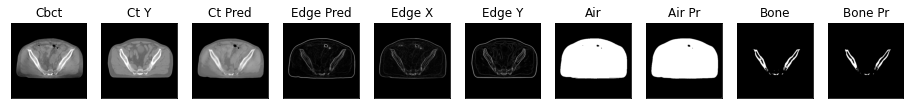

78it [00:49,  1.96it/s]

ssim score = 0.808710515499115
psnr score = 22.221466064453125
snr score = 12.807708740234375
mae error = 0.030909329652786255
air dice score = 0.9965471085231032
bone dice score = 0.8800653594790839
contour dice score = 0.5685115456581116


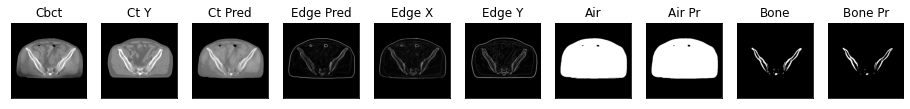

79it [00:50,  2.03it/s]

ssim score = 0.8101727366447449
psnr score = 22.649627685546875
snr score = 13.224601745605469
mae error = 0.0295754112303257
air dice score = 0.9963697386896843
bone dice score = 0.8799006563796363
contour dice score = 0.582073450088501


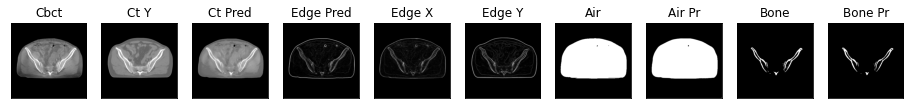

80it [00:50,  2.02it/s]

ssim score = 0.8090505599975586
psnr score = 22.661096572875977
snr score = 13.235330581665039
mae error = 0.029599657282233238
air dice score = 0.9963480756506902
bone dice score = 0.8832016489199038
contour dice score = 0.5613079071044922


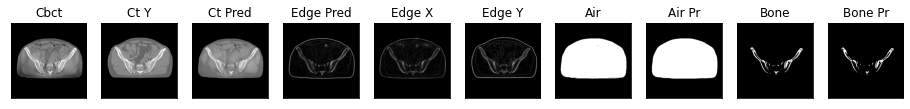

81it [00:51,  1.72it/s]

ssim score = 0.8628635406494141
psnr score = 23.805715560913086
snr score = 14.239850997924805
mae error = 0.022097907960414886
air dice score = 0.9969972840155178
bone dice score = 0.9168474331194199
contour dice score = 0.44527098536491394


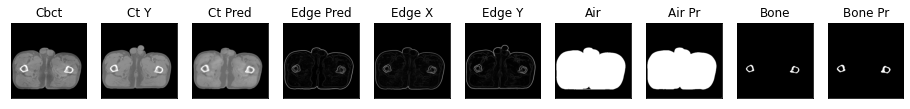

82it [00:51,  1.77it/s]

ssim score = 0.8634564280509949
psnr score = 24.079734802246094
snr score = 14.578262329101562
mae error = 0.02172728255391121
air dice score = 0.9965647706944889
bone dice score = 0.9010844561320708
contour dice score = 0.4342797100543976


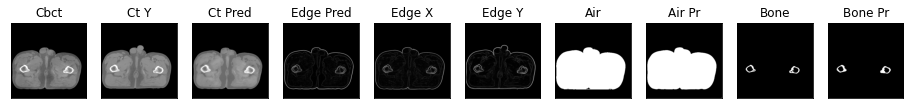

83it [00:52,  1.81it/s]

ssim score = 0.8711140155792236
psnr score = 25.52770233154297
snr score = 16.16543960571289
mae error = 0.01896713301539421
air dice score = 0.9970816740081235
bone dice score = 0.9225011008383421
contour dice score = 0.44625574350357056


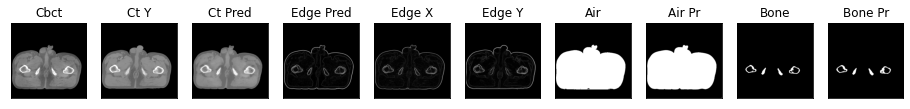

84it [00:52,  1.86it/s]

ssim score = 0.869688868522644
psnr score = 25.53609848022461
snr score = 16.29532814025879
mae error = 0.01902645267546177
air dice score = 0.9976882661996516
bone dice score = 0.9033622330322825
contour dice score = 0.446391761302948


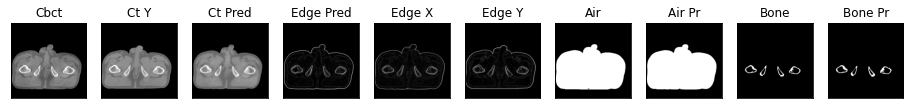

85it [00:53,  1.88it/s]

ssim score = 0.8663640022277832
psnr score = 25.31399917602539
snr score = 16.097400665283203
mae error = 0.01957535743713379
air dice score = 0.9981365591564839
bone dice score = 0.890158172234399
contour dice score = 0.4872727394104004


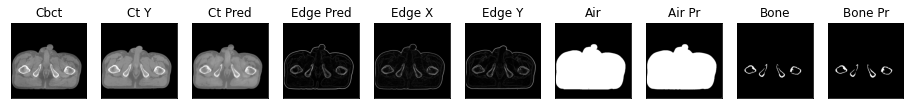

86it [00:53,  1.92it/s]

ssim score = 0.8629699349403381
psnr score = 25.118553161621094
snr score = 15.897561073303223
mae error = 0.01995948888361454
air dice score = 0.9982863833383747
bone dice score = 0.8887116075012224
contour dice score = 0.4863731563091278


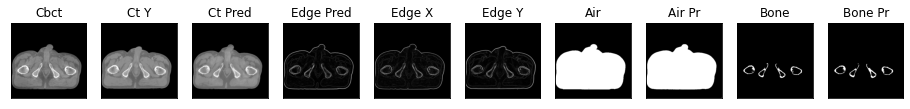

87it [00:54,  1.91it/s]

ssim score = 0.8645734190940857
psnr score = 24.68446922302246
snr score = 15.469730377197266
mae error = 0.02062445692718029
air dice score = 0.9980078291539103
bone dice score = 0.8825396825420131
contour dice score = 0.472075879573822


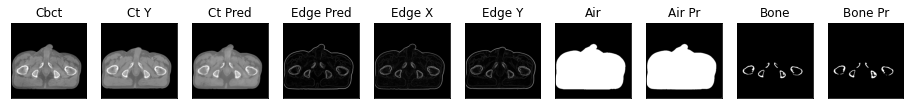

88it [00:54,  2.01it/s]

ssim score = 0.8623603582382202
psnr score = 24.507131576538086
snr score = 15.270837783813477
mae error = 0.020716916769742966
air dice score = 0.9980762368710938
bone dice score = 0.8890212428054591
contour dice score = 0.5


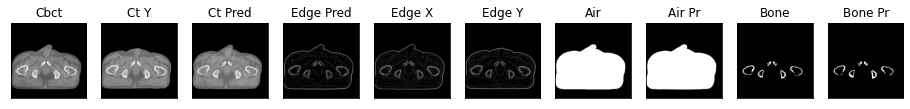

89it [00:55,  2.00it/s]

ssim score = 0.8625768423080444
psnr score = 24.468109130859375
snr score = 15.248725891113281
mae error = 0.020861759781837463
air dice score = 0.9978687989048443
bone dice score = 0.900786797161758
contour dice score = 0.4838196337223053


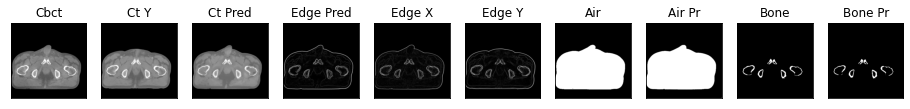

90it [00:55,  1.99it/s]

ssim score = 0.8638491034507751
psnr score = 24.712059020996094
snr score = 15.561269760131836
mae error = 0.02055780030786991
air dice score = 0.9976731111596983
bone dice score = 0.8900766078765352
contour dice score = 0.5306994318962097


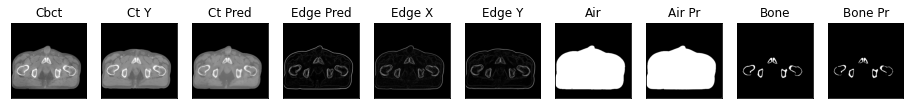

91it [00:56,  1.65it/s]

ssim score = 0.8630872368812561
psnr score = 24.99942398071289
snr score = 15.9299898147583
mae error = 0.020769106224179268
air dice score = 0.9975382203057643
bone dice score = 0.8721779548493994
contour dice score = 0.5402792692184448


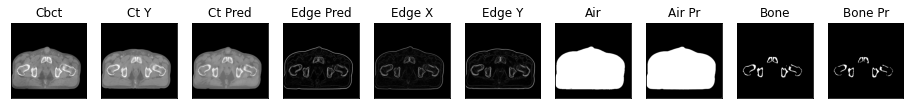

92it [00:57,  1.70it/s]

ssim score = 0.8624179363250732
psnr score = 25.12993812561035
snr score = 16.111207962036133
mae error = 0.02127394638955593
air dice score = 0.9975445831300288
bone dice score = 0.8429404145103151
contour dice score = 0.6003227829933167


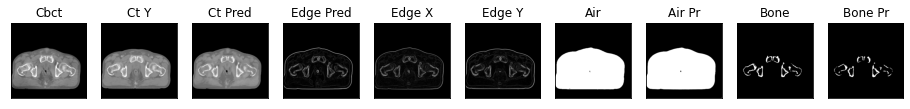

93it [00:57,  1.73it/s]

ssim score = 0.8638578057289124
psnr score = 25.390159606933594
snr score = 16.487699508666992
mae error = 0.021654674783349037
air dice score = 0.9981130436842245
bone dice score = 0.8060754832800541
contour dice score = 0.5952637195587158


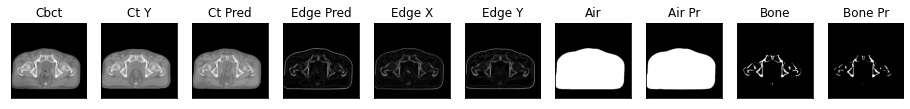

94it [00:58,  1.79it/s]

ssim score = 0.8651357889175415
psnr score = 25.080089569091797
snr score = 16.13939094543457
mae error = 0.02159329317510128
air dice score = 0.9982617806033778
bone dice score = 0.8256000000027904
contour dice score = 0.6429725289344788


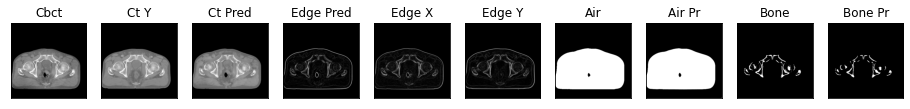

95it [00:58,  1.85it/s]

ssim score = 0.8586747050285339
psnr score = 24.413537979125977
snr score = 15.37717056274414
mae error = 0.022148262709379196
air dice score = 0.9977990668043268
bone dice score = 0.8336272780741677
contour dice score = 0.5957906246185303


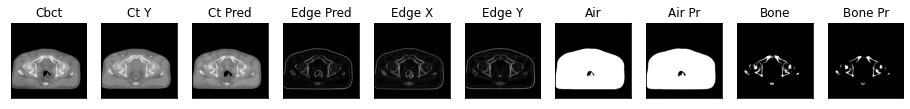

96it [00:59,  1.89it/s]

ssim score = 0.8639963865280151
psnr score = 24.324167251586914
snr score = 15.128040313720703
mae error = 0.0215008407831192
air dice score = 0.9980098780949634
bone dice score = 0.8690271571009105
contour dice score = 0.6139686107635498


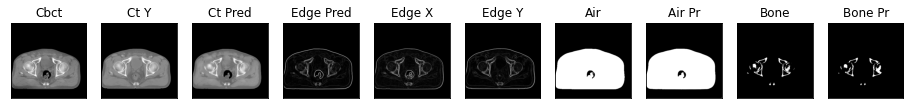

97it [00:59,  1.94it/s]

ssim score = 0.8650466799736023
psnr score = 24.092538833618164
snr score = 14.779987335205078
mae error = 0.02164105884730816
air dice score = 0.997728179530818
bone dice score = 0.864610559333253
contour dice score = 0.5771738886833191


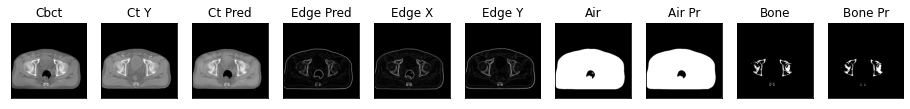

98it [01:00,  1.96it/s]

ssim score = 0.8612512946128845
psnr score = 23.948612213134766
snr score = 14.590968132019043
mae error = 0.021990802139043808
air dice score = 0.9981971941785776
bone dice score = 0.8838827232088142
contour dice score = 0.5834242105484009


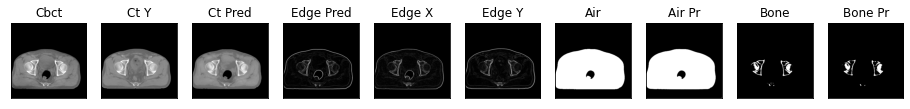

99it [01:00,  1.96it/s]

ssim score = 0.8544515371322632
psnr score = 23.388694763183594
snr score = 14.03772258758545
mae error = 0.0233723483979702
air dice score = 0.9982353472262135
bone dice score = 0.8973421926927352
contour dice score = 0.5267759561538696


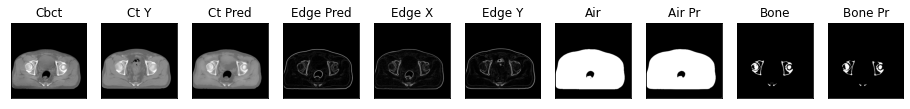

100it [01:01,  1.98it/s]

ssim score = 0.8569422960281372
psnr score = 23.071691513061523
snr score = 13.750823974609375
mae error = 0.024038946256041527
air dice score = 0.9984294958764002
bone dice score = 0.9080788804085865
contour dice score = 0.5093099474906921


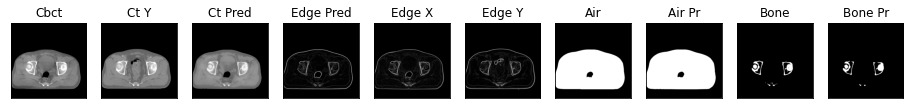

101it [01:02,  1.68it/s]

ssim score = 0.8639874458312988
psnr score = 23.660268783569336
snr score = 14.296813011169434
mae error = 0.022291328758001328
air dice score = 0.9977655099894865
bone dice score = 0.9044923947664575
contour dice score = 0.4964383542537689


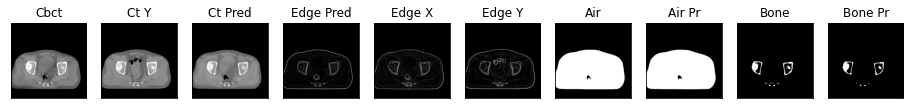

102it [01:02,  1.72it/s]

ssim score = 0.8657759428024292
psnr score = 23.93436622619629
snr score = 14.480709075927734
mae error = 0.02153821662068367
air dice score = 0.9980867241749014
bone dice score = 0.8961769842830162
contour dice score = 0.49561402201652527


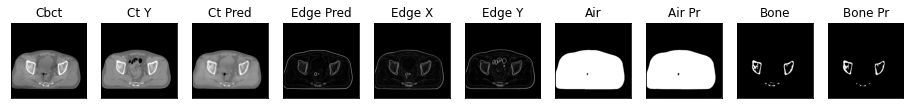

103it [01:03,  1.79it/s]

ssim score = 0.8658757209777832
psnr score = 23.53966522216797
snr score = 14.020279884338379
mae error = 0.022401345893740654
air dice score = 0.998116698055034
bone dice score = 0.9076923076941763
contour dice score = 0.5436573028564453


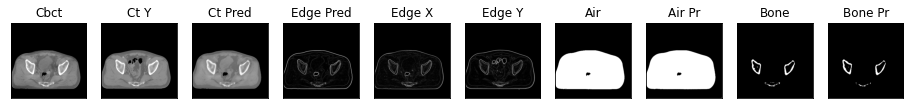

104it [01:03,  1.87it/s]

ssim score = 0.8624053001403809
psnr score = 23.65631866455078
snr score = 14.13663101196289
mae error = 0.022560177370905876
air dice score = 0.9976912291895814
bone dice score = 0.8964761730893468
contour dice score = 0.5278236865997314


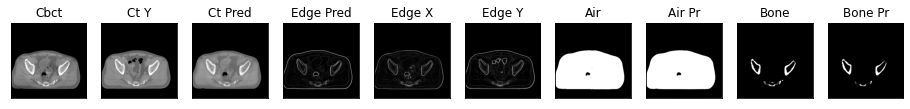

105it [01:04,  1.88it/s]

ssim score = 0.8590614199638367
psnr score = 23.57084083557129
snr score = 14.127320289611816
mae error = 0.023105250671505928
air dice score = 0.9972872619996292
bone dice score = 0.8813662702061396
contour dice score = 0.5867403149604797


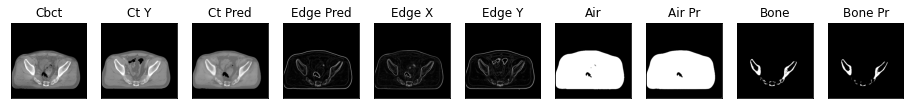

106it [01:04,  1.97it/s]

ssim score = 0.8617334365844727
psnr score = 23.751522064208984
snr score = 14.343584060668945
mae error = 0.023016879335045815
air dice score = 0.997499978668762
bone dice score = 0.8658959537591634
contour dice score = 0.5873894095420837


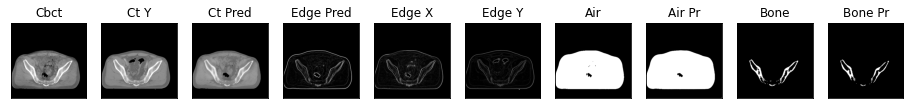

107it [01:05,  1.97it/s]

ssim score = 0.8624641299247742
psnr score = 24.37647247314453
snr score = 14.90683650970459
mae error = 0.02186158299446106
air dice score = 0.9979319517741468
bone dice score = 0.8526105036215523
contour dice score = 0.5771365165710449


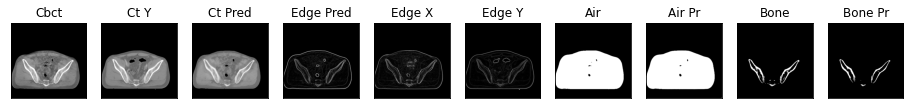

108it [01:05,  1.97it/s]

ssim score = 0.858384907245636
psnr score = 24.172164916992188
snr score = 14.641266822814941
mae error = 0.022534217685461044
air dice score = 0.9976644406767952
bone dice score = 0.850803858523299
contour dice score = 0.5120448470115662


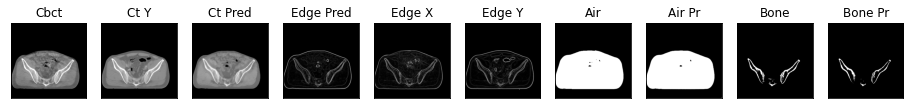

109it [01:06,  1.93it/s]

ssim score = 0.7957044839859009
psnr score = 22.208051681518555
snr score = 13.905357360839844
mae error = 0.03150120750069618
air dice score = 0.9970067156261316
bone dice score = 0.9420825631564361
contour dice score = 0.43973508477211


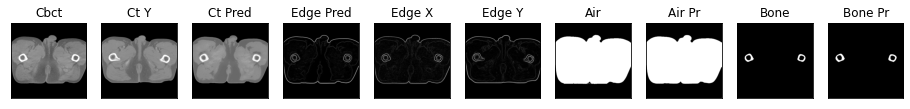

110it [01:06,  1.95it/s]

ssim score = 0.787541389465332
psnr score = 21.936323165893555
snr score = 13.737918853759766
mae error = 0.03251860663294792
air dice score = 0.9971654694065182
bone dice score = 0.9435326842852981
contour dice score = 0.4403914511203766


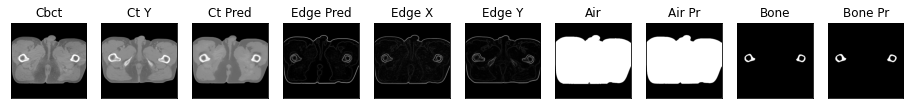

111it [01:07,  1.66it/s]

ssim score = 0.7809694409370422
psnr score = 21.669086456298828
snr score = 13.598641395568848
mae error = 0.03425804525613785
air dice score = 0.9972574099849085
bone dice score = 0.9117978795418047
contour dice score = 0.43637993931770325


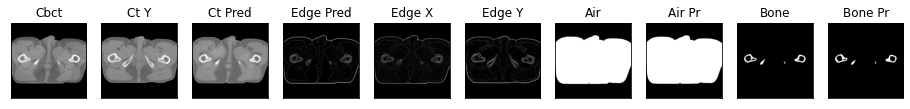

112it [01:08,  1.74it/s]

ssim score = 0.7760381698608398
psnr score = 21.469133377075195
snr score = 13.430975914001465
mae error = 0.034072279930114746
air dice score = 0.9970707473109478
bone dice score = 0.9081155909342773
contour dice score = 0.40197840332984924


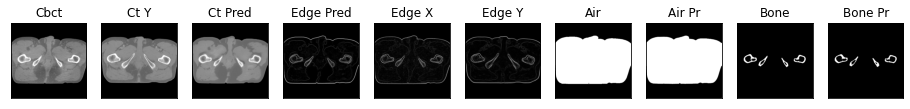

113it [01:08,  1.82it/s]

ssim score = 0.7644688487052917
psnr score = 21.27002716064453
snr score = 13.262107849121094
mae error = 0.03574229031801224
air dice score = 0.9972131827556205
bone dice score = 0.8828983516503623
contour dice score = 0.3985539972782135


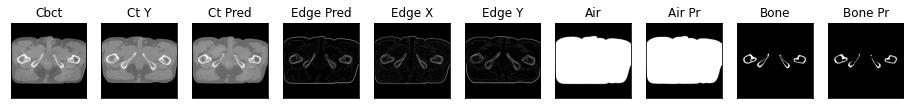

114it [01:09,  1.83it/s]

ssim score = 0.7582833170890808
psnr score = 21.094242095947266
snr score = 13.120738983154297
mae error = 0.03741855174303055
air dice score = 0.9973559148301744
bone dice score = 0.8856064336142195
contour dice score = 0.41919419169425964


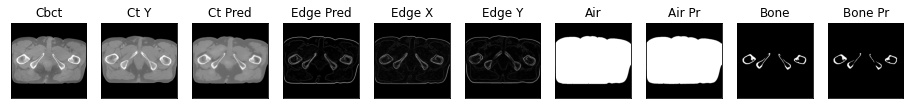

115it [01:09,  1.92it/s]

ssim score = 0.7496362328529358
psnr score = 20.79174041748047
snr score = 12.83854866027832
mae error = 0.03859845548868179
air dice score = 0.9970465530547014
bone dice score = 0.8769614312967157
contour dice score = 0.41550248861312866


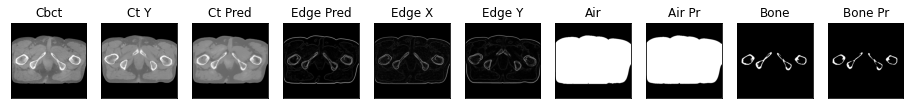

116it [01:10,  1.92it/s]

ssim score = 0.7515724897384644
psnr score = 20.74672508239746
snr score = 12.83260726928711
mae error = 0.03809100389480591
air dice score = 0.9965763145851336
bone dice score = 0.8732846715346966
contour dice score = 0.43836843967437744


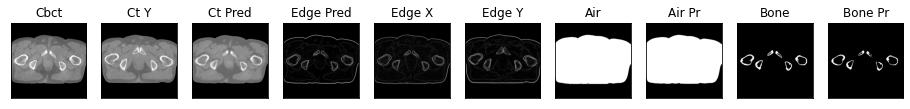

117it [01:10,  1.91it/s]

ssim score = 0.7530165910720825
psnr score = 20.84944725036621
snr score = 12.984009742736816
mae error = 0.03812095522880554
air dice score = 0.9959681623857379
bone dice score = 0.8713324745975192
contour dice score = 0.4330434799194336


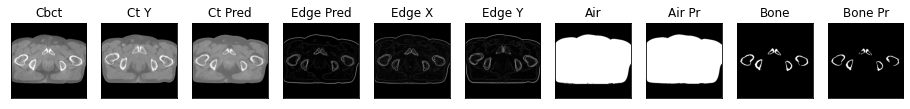

118it [01:11,  1.90it/s]

ssim score = 0.7451171278953552
psnr score = 20.679655075073242
snr score = 12.836827278137207
mae error = 0.04032665491104126
air dice score = 0.9960797938562228
bone dice score = 0.8536244052637332
contour dice score = 0.448129266500473


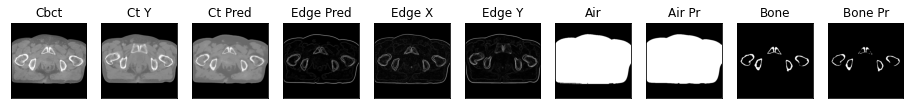

119it [01:11,  1.90it/s]

ssim score = 0.7338361144065857
psnr score = 20.651016235351562
snr score = 12.850966453552246
mae error = 0.04177168756723404
air dice score = 0.9968231230433344
bone dice score = 0.8285637871111452
contour dice score = 0.4482317864894867


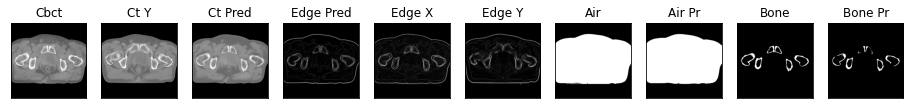

120it [01:12,  1.95it/s]

ssim score = 0.733386754989624
psnr score = 20.638782501220703
snr score = 12.897071838378906
mae error = 0.0421910285949707
air dice score = 0.9968509467309161
bone dice score = 0.8272058823550588
contour dice score = 0.40799635648727417


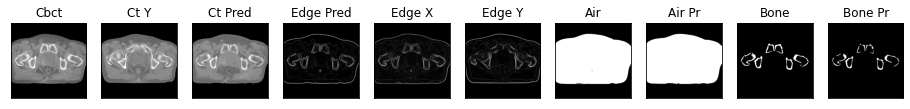

121it [01:12,  1.66it/s]

ssim score = 0.7281395792961121
psnr score = 20.58932876586914
snr score = 12.772244453430176
mae error = 0.04360619932413101
air dice score = 0.9974811372837703
bone dice score = 0.7872462438377422
contour dice score = 0.3959853947162628


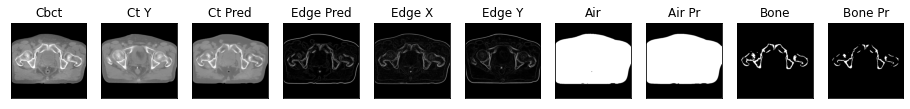

122it [01:13,  1.71it/s]

ssim score = 0.7325894236564636
psnr score = 20.53022575378418
snr score = 12.605925559997559
mae error = 0.043684232980012894
air dice score = 0.9974297789149886
bone dice score = 0.776941229354119
contour dice score = 0.4087791442871094


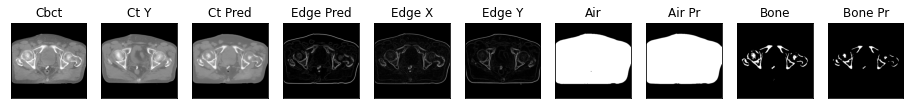

123it [01:14,  1.77it/s]

ssim score = 0.7424159049987793
psnr score = 20.701332092285156
snr score = 12.65394401550293
mae error = 0.04224574565887451
air dice score = 0.9977668807698519
bone dice score = 0.7452092073960175
contour dice score = 0.46005508303642273


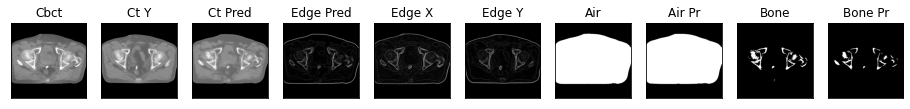

124it [01:14,  1.78it/s]

ssim score = 0.7454116344451904
psnr score = 20.847740173339844
snr score = 12.687919616699219
mae error = 0.04092687740921974
air dice score = 0.9980268851324076
bone dice score = 0.8209093007175061
contour dice score = 0.46104195713996887


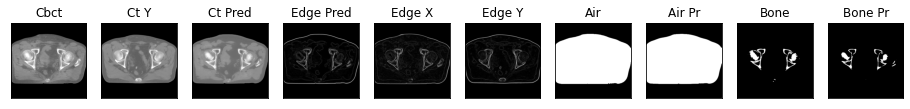

125it [01:15,  1.84it/s]

ssim score = 0.7457204461097717
psnr score = 21.084421157836914
snr score = 12.873953819274902
mae error = 0.03849329799413681
air dice score = 0.9980968247632611
bone dice score = 0.8588446842002826
contour dice score = 0.48934197425842285


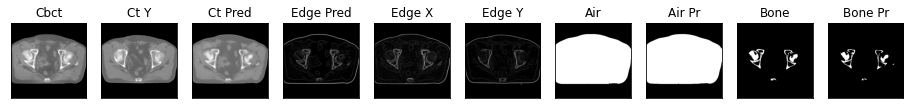

126it [01:15,  1.92it/s]

ssim score = 0.7427583932876587
psnr score = 20.849782943725586
snr score = 12.67147445678711
mae error = 0.03993524983525276
air dice score = 0.9980957688913671
bone dice score = 0.8676937551467988
contour dice score = 0.49604466557502747


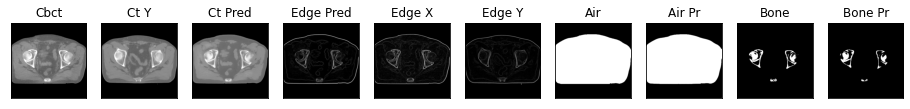

127it [01:16,  1.92it/s]

ssim score = 0.7426558136940002
psnr score = 20.633460998535156
snr score = 12.4686279296875
mae error = 0.04056806489825249
air dice score = 0.9980650425457523
bone dice score = 0.8888335615599547
contour dice score = 0.4754328429698944


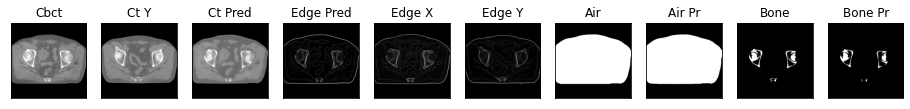

128it [01:16,  1.93it/s]

ssim score = 0.7401454448699951
psnr score = 20.314922332763672
snr score = 12.008596420288086
mae error = 0.042331498116254807
air dice score = 0.9978617582790974
bone dice score = 0.8868209255547432
contour dice score = 0.4353163242340088


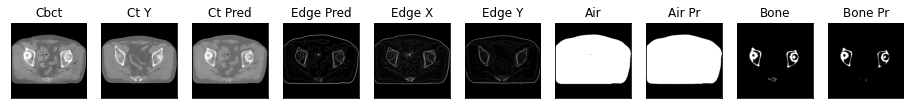

129it [01:17,  1.95it/s]

ssim score = 0.7474904656410217
psnr score = 20.37640380859375
snr score = 12.010770797729492
mae error = 0.04201778024435043
air dice score = 0.9977560912405118
bone dice score = 0.8783922546592579
contour dice score = 0.420255571603775


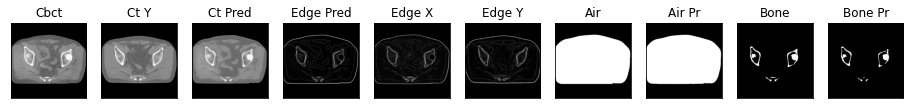

130it [01:17,  1.93it/s]

ssim score = 0.7444814443588257
psnr score = 20.64820098876953
snr score = 12.308212280273438
mae error = 0.040580976754426956
air dice score = 0.9979052262829022
bone dice score = 0.8684571652642922
contour dice score = 0.4310753345489502


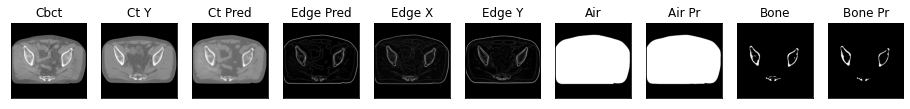

131it [01:18,  1.66it/s]

ssim score = 0.7402702569961548
psnr score = 20.566251754760742
snr score = 12.299078941345215
mae error = 0.04083381965756416
air dice score = 0.9974057810622033
bone dice score = 0.8677579547568924
contour dice score = 0.4204545319080353


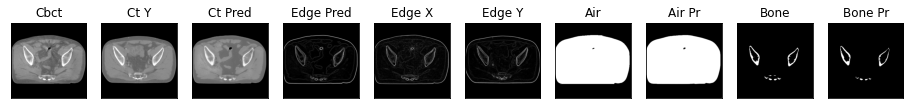

132it [01:18,  1.73it/s]

ssim score = 0.7318309545516968
psnr score = 20.263898849487305
snr score = 12.125955581665039
mae error = 0.04243916645646095
air dice score = 0.9971857298540189
bone dice score = 0.8642783327615522
contour dice score = 0.42482098937034607


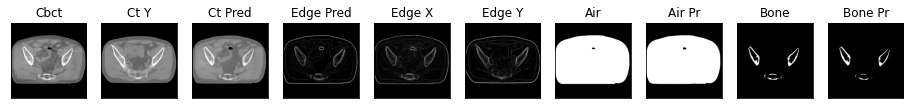

133it [01:19,  1.79it/s]

ssim score = 0.7285700440406799
psnr score = 20.181255340576172
snr score = 12.07727336883545
mae error = 0.04229873791337013
air dice score = 0.9971032995886824
bone dice score = 0.8606949314654018
contour dice score = 0.4234277606010437


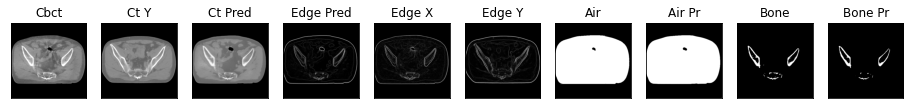

134it [01:19,  1.83it/s]

ssim score = 0.7152273058891296
psnr score = 20.12559700012207
snr score = 11.99182415008545
mae error = 0.04326707497239113
air dice score = 0.9969741077845776
bone dice score = 0.8428343100713528
contour dice score = 0.38535645604133606


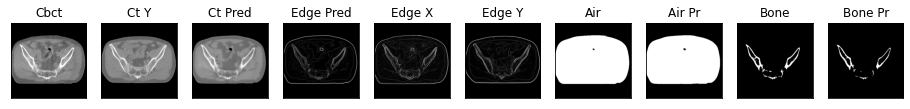

135it [01:20,  1.92it/s]

ssim score = 0.7167059779167175
psnr score = 20.3917236328125
snr score = 12.194575309753418
mae error = 0.042063772678375244
air dice score = 0.997303863654266
bone dice score = 0.8175459049866286
contour dice score = 0.40135395526885986


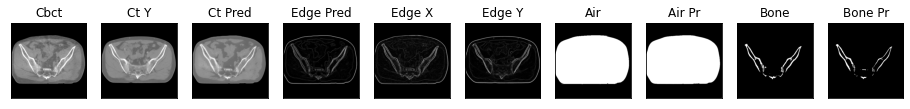

136it [01:20,  1.93it/s]

ssim score = 0.8271200656890869
psnr score = 23.17244529724121
snr score = 14.649837493896484
mae error = 0.026888299733400345
air dice score = 0.99818220939464
bone dice score = 0.8433413397405479
contour dice score = 0.5694165229797363


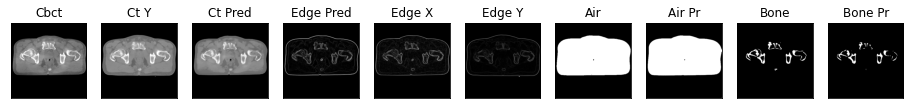

137it [01:21,  1.92it/s]

ssim score = 0.8292616009712219
psnr score = 23.125877380371094
snr score = 14.643279075622559
mae error = 0.02729952521622181
air dice score = 0.9982081651164706
bone dice score = 0.839608329887745
contour dice score = 0.5320545434951782


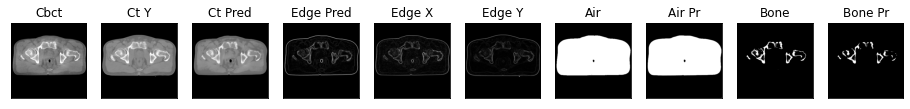

138it [01:22,  1.88it/s]

ssim score = 0.8284880518913269
psnr score = 23.248859405517578
snr score = 14.7740478515625
mae error = 0.027670038864016533
air dice score = 0.9979315476190491
bone dice score = 0.816741752654894
contour dice score = 0.5410334467887878


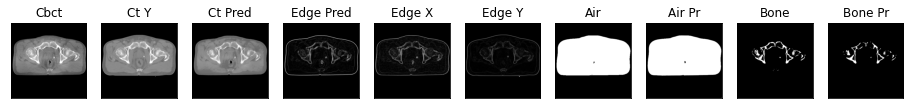

139it [01:22,  1.89it/s]

ssim score = 0.8316864371299744
psnr score = 23.23635482788086
snr score = 14.703125953674316
mae error = 0.02716634050011635
air dice score = 0.9979322648791099
bone dice score = 0.8362557324003742
contour dice score = 0.540375828742981


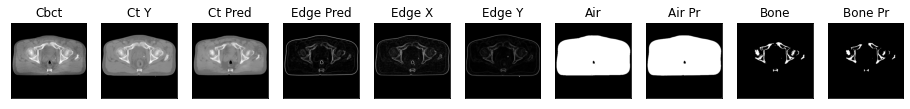

140it [01:23,  1.90it/s]

ssim score = 0.8394852876663208
psnr score = 23.506153106689453
snr score = 14.817298889160156
mae error = 0.024579431861639023
air dice score = 0.9981436292049058
bone dice score = 0.8684578350696
contour dice score = 0.5310907363891602


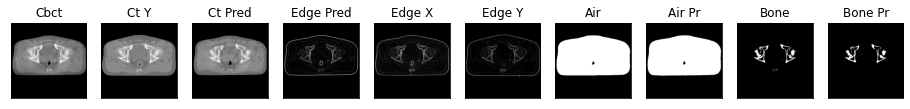

141it [01:23,  1.63it/s]

ssim score = 0.8424985408782959
psnr score = 23.603580474853516
snr score = 14.893922805786133
mae error = 0.024083338677883148
air dice score = 0.9978461700099828
bone dice score = 0.872770160697733
contour dice score = 0.5562372207641602


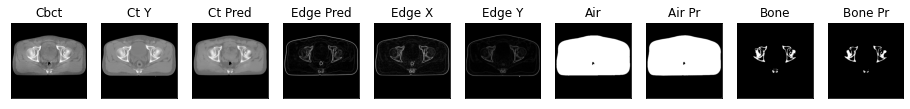

142it [01:24,  1.71it/s]

ssim score = 0.83978670835495
psnr score = 23.558692932128906
snr score = 14.833406448364258
mae error = 0.024211261421442032
air dice score = 0.9980277618861235
bone dice score = 0.8826847967614251
contour dice score = 0.5623396635055542


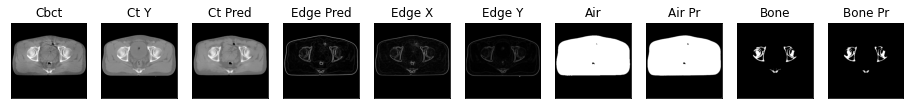

143it [01:24,  1.77it/s]

ssim score = 0.8351460695266724
psnr score = 22.94304084777832
snr score = 14.227118492126465
mae error = 0.02592957392334938
air dice score = 0.9980799467827784
bone dice score = 0.8848289973708736
contour dice score = 0.5427394509315491


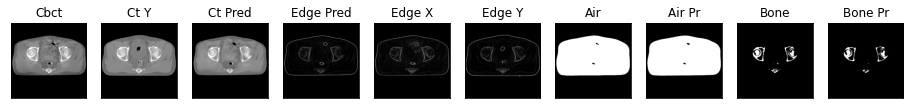

144it [01:25,  1.81it/s]

ssim score = 0.8319253325462341
psnr score = 23.02790641784668
snr score = 14.367762565612793
mae error = 0.026447098702192307
air dice score = 0.998395057989887
bone dice score = 0.9020788530479988
contour dice score = 0.5429162383079529


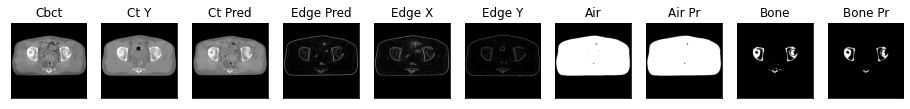

145it [01:25,  1.88it/s]

ssim score = 0.8289731740951538
psnr score = 22.621150970458984
snr score = 13.93907642364502
mae error = 0.027816252782940865
air dice score = 0.9980368583646588
bone dice score = 0.8971132494463788
contour dice score = 0.5444155931472778


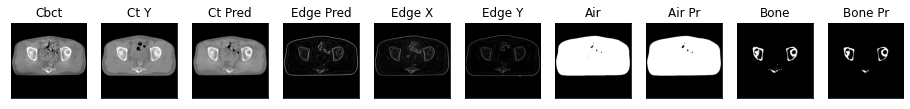

146it [01:26,  1.89it/s]

ssim score = 0.8287590146064758
psnr score = 22.12485122680664
snr score = 13.3720064163208
mae error = 0.028447741642594337
air dice score = 0.9977091892057013
bone dice score = 0.8687169312191019
contour dice score = 0.5894626975059509


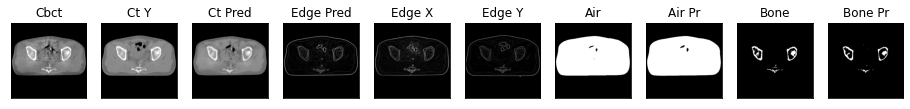

147it [01:27,  1.88it/s]

ssim score = 0.8303530216217041
psnr score = 22.323503494262695
snr score = 13.526764869689941
mae error = 0.027708405628800392
air dice score = 0.9977081391617918
bone dice score = 0.8745419647552863
contour dice score = 0.586694598197937


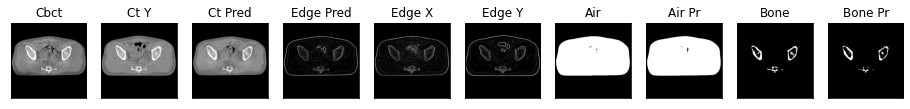

148it [01:27,  1.89it/s]

ssim score = 0.8322856426239014
psnr score = 22.531709671020508
snr score = 13.73387336730957
mae error = 0.027038270607590675
air dice score = 0.9979904893388571
bone dice score = 0.8871373469748929
contour dice score = 0.6022070646286011


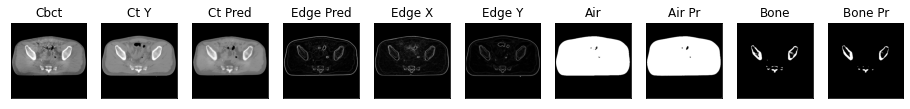

149it [01:28,  1.90it/s]

ssim score = 0.8277351260185242
psnr score = 22.55718421936035
snr score = 13.772706031799316
mae error = 0.02756890468299389
air dice score = 0.9973120971033823
bone dice score = 0.8990028948231102
contour dice score = 0.5917721390724182


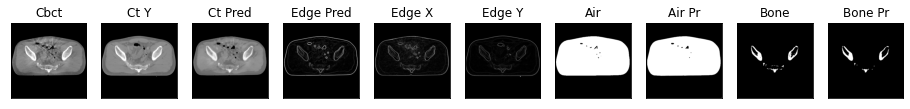

150it [01:28,  1.89it/s]

ssim score = 0.824967622756958
psnr score = 22.39221954345703
snr score = 13.662944793701172
mae error = 0.028422707691788673
air dice score = 0.9970905939521518
bone dice score = 0.8752425838664369
contour dice score = 0.5898520350456238


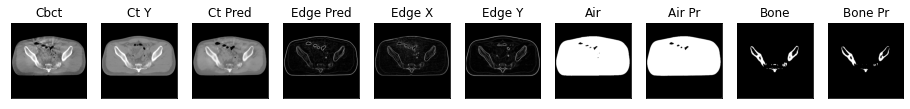

151it [01:29,  1.64it/s]

ssim score = 0.8255640268325806
psnr score = 21.954452514648438
snr score = 13.244548797607422
mae error = 0.029749685898423195
air dice score = 0.9967736931906338
bone dice score = 0.8594733829441976
contour dice score = 0.5844362378120422


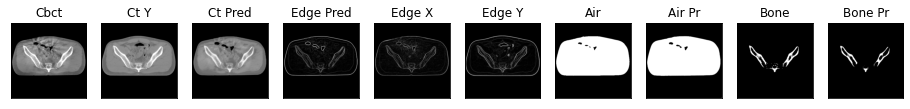

152it [01:29,  1.71it/s]

ssim score = 0.8288590312004089
psnr score = 22.16547393798828
snr score = 13.400832176208496
mae error = 0.029170652851462364
air dice score = 0.9974595306327957
bone dice score = 0.8465855940154882
contour dice score = 0.5045140981674194


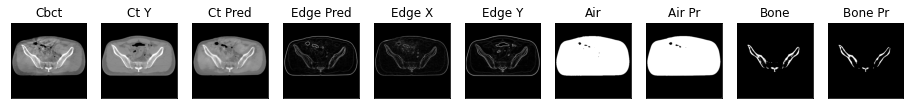

153it [01:30,  1.79it/s]

ssim score = 0.8319780230522156
psnr score = 22.322416305541992
snr score = 13.521421432495117
mae error = 0.028240442276000977
air dice score = 0.9971352029360321
bone dice score = 0.8394024276402209
contour dice score = 0.4874666631221771


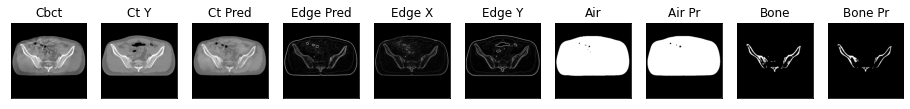

154it [01:30,  1.80it/s]

ssim score = 0.8351902961730957
psnr score = 22.422523498535156
snr score = 13.621599197387695
mae error = 0.027895446866750717
air dice score = 0.9973811848201716
bone dice score = 0.830097775261016
contour dice score = 0.43790149688720703


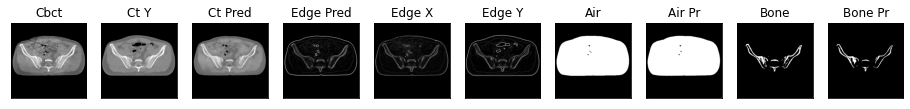

155it [01:31,  1.87it/s]

ssim score = 0.830745279788971
psnr score = 22.579639434814453
snr score = 13.77729320526123
mae error = 0.027894815430045128
air dice score = 0.9976799224054335
bone dice score = 0.8261870503622132
contour dice score = 0.4383414089679718


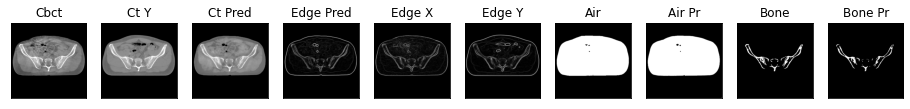

156it [01:31,  1.91it/s]

ssim score = 0.824985146522522
psnr score = 22.08768653869629
snr score = 13.290377616882324
mae error = 0.02929648384451866
air dice score = 0.9967682903087671
bone dice score = 0.809011927553983
contour dice score = 0.44155845046043396


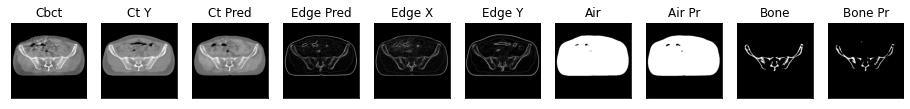

157it [01:32,  1.90it/s]

ssim score = 0.8205959796905518
psnr score = 21.677101135253906
snr score = 12.862521171569824
mae error = 0.030833639204502106
air dice score = 0.9963072493702011
bone dice score = 0.8104982206433793
contour dice score = 0.4997278153896332


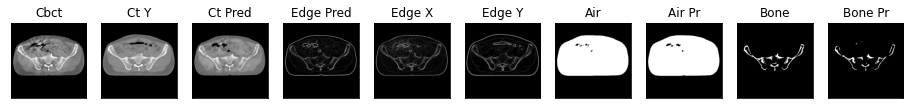

158it [01:32,  1.92it/s]

ssim score = 0.8158650398254395
psnr score = 21.334827423095703
snr score = 12.501625061035156
mae error = 0.03197338059544563
air dice score = 0.9961173289738461
bone dice score = 0.8210700041284408
contour dice score = 0.46981340646743774


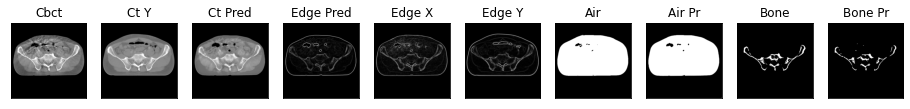

159it [01:33,  1.95it/s]

ssim score = 0.8073672652244568
psnr score = 21.058990478515625
snr score = 12.179849624633789
mae error = 0.03307311236858368
air dice score = 0.9959228093972572
bone dice score = 0.824887237996486
contour dice score = 0.46051904559135437


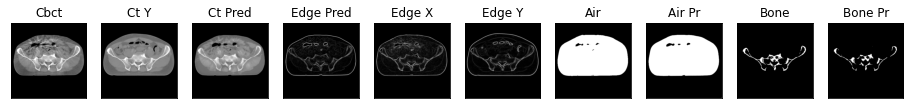

160it [01:34,  1.91it/s]

ssim score = 0.8036894798278809
psnr score = 21.00768280029297
snr score = 12.074745178222656
mae error = 0.03336586058139801
air dice score = 0.995581038060095
bone dice score = 0.8408447077022811
contour dice score = 0.4075513482093811


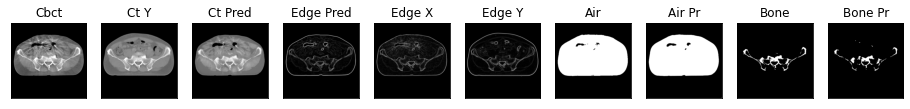

161it [01:34,  1.64it/s]

ssim score = 0.798221230506897
psnr score = 20.66607666015625
snr score = 11.763601303100586
mae error = 0.035273365676403046
air dice score = 0.995593241910341
bone dice score = 0.8400869231772966
contour dice score = 0.40356743335723877


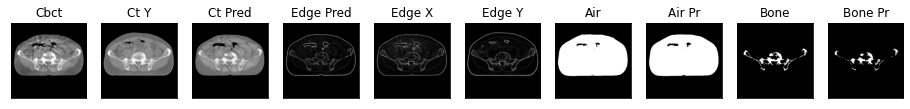

162it [01:35,  1.70it/s]

ssim score = 0.7938166856765747
psnr score = 20.445404052734375
snr score = 11.487702369689941
mae error = 0.03563579544425011
air dice score = 0.9957590638053667
bone dice score = 0.83372984404132
contour dice score = 0.4240400791168213


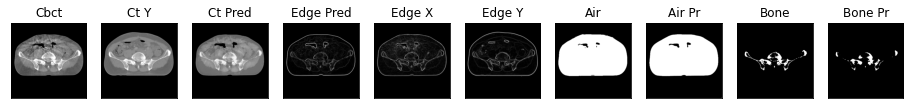

163it [01:35,  1.77it/s]

ssim score = 0.7992335557937622
psnr score = 21.117765426635742
snr score = 12.012533187866211
mae error = 0.03274683281779289
air dice score = 0.9965149013884597
bone dice score = 0.8673331532036297
contour dice score = 0.3559037446975708


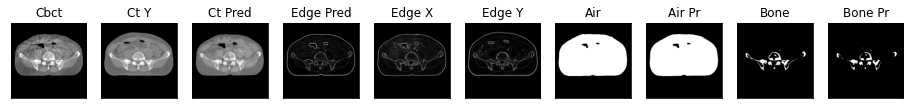

164it [01:36,  1.77it/s]

ssim score = 0.8532714247703552
psnr score = 24.84107780456543
snr score = 15.221988677978516
mae error = 0.024732913821935654
air dice score = 0.9958762734495482
bone dice score = 0.8953575909687489
contour dice score = 0.5499514937400818


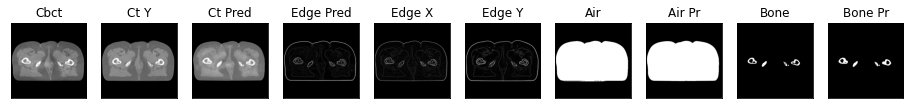

165it [01:36,  1.79it/s]

ssim score = 0.854442834854126
psnr score = 25.146995544433594
snr score = 15.648919105529785
mae error = 0.023470353335142136
air dice score = 0.9963802098599006
bone dice score = 0.8965813803505358
contour dice score = 0.523244321346283


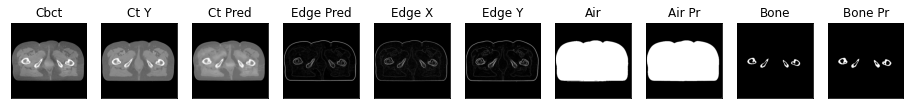

166it [01:37,  1.85it/s]

ssim score = 0.8519319891929626
psnr score = 25.219772338867188
snr score = 15.80461311340332
mae error = 0.0231118593364954
air dice score = 0.9962567000699165
bone dice score = 0.8925425719339882
contour dice score = 0.482421875


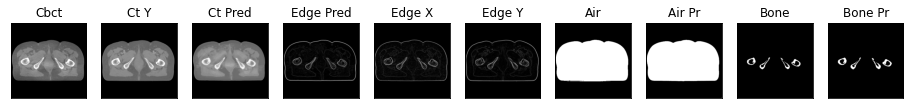

167it [01:37,  1.92it/s]

ssim score = 0.8486883640289307
psnr score = 25.17805290222168
snr score = 15.826339721679688
mae error = 0.023177092894911766
air dice score = 0.9963908335869922
bone dice score = 0.8915450870119257
contour dice score = 0.4736328125


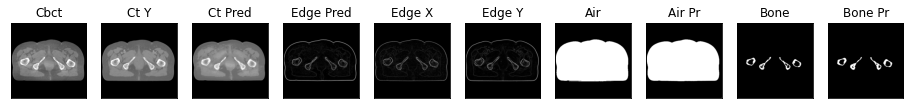

168it [01:38,  1.92it/s]

ssim score = 0.8478663563728333
psnr score = 25.085763931274414
snr score = 15.762511253356934
mae error = 0.023175660520792007
air dice score = 0.9961142890160078
bone dice score = 0.9179320935008031
contour dice score = 0.47834646701812744


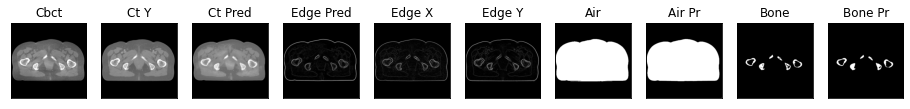

169it [01:39,  1.93it/s]

ssim score = 0.8501092195510864
psnr score = 25.002368927001953
snr score = 15.702072143554688
mae error = 0.023199785500764847
air dice score = 0.9962677964147817
bone dice score = 0.9157706093205059
contour dice score = 0.4785992205142975


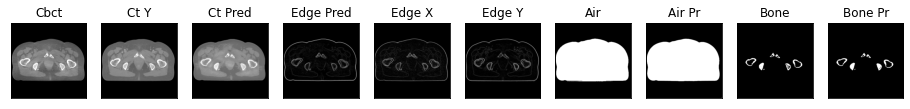

170it [01:39,  1.93it/s]

ssim score = 0.8478675484657288
psnr score = 24.918840408325195
snr score = 15.64986801147461
mae error = 0.02312265709042549
air dice score = 0.996183727298211
bone dice score = 0.9162387108213876
contour dice score = 0.458192378282547


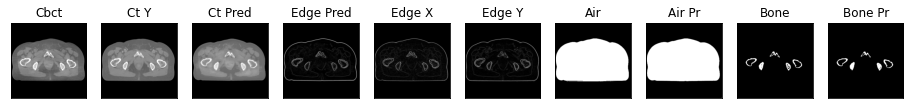

171it [01:40,  1.64it/s]

ssim score = 0.8477515578269958
psnr score = 24.81947898864746
snr score = 15.59887409210205
mae error = 0.02326236665248871
air dice score = 0.9961321248914654
bone dice score = 0.9019883864173502
contour dice score = 0.4571966230869293


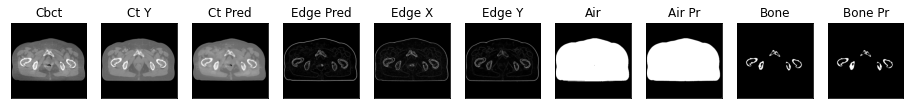

172it [01:40,  1.71it/s]

ssim score = 0.8473536968231201
psnr score = 24.45634651184082
snr score = 15.278483390808105
mae error = 0.023669205605983734
air dice score = 0.9958417420156449
bone dice score = 0.9084199932923781
contour dice score = 0.4514889419078827


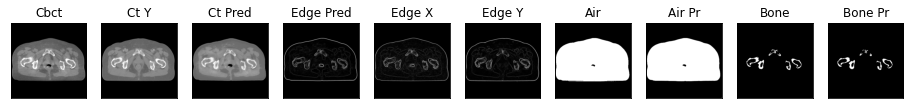

173it [01:41,  1.76it/s]

ssim score = 0.8469498157501221
psnr score = 24.399412155151367
snr score = 15.30925178527832
mae error = 0.023582203313708305
air dice score = 0.995532251113349
bone dice score = 0.882230172929603
contour dice score = 0.4319775700569153


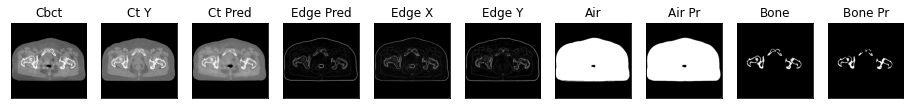

174it [01:41,  1.85it/s]

ssim score = 0.8499414920806885
psnr score = 25.349905014038086
snr score = 16.373018264770508
mae error = 0.02191159687936306
air dice score = 0.9953824160114401
bone dice score = 0.8803646031158329
contour dice score = 0.42382270097732544


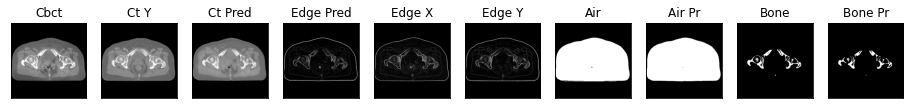

175it [01:42,  1.87it/s]

ssim score = 0.8482912182807922
psnr score = 24.365764617919922
snr score = 15.260323524475098
mae error = 0.02419930510222912
air dice score = 0.9952446430617657
bone dice score = 0.8813445378171203
contour dice score = 0.43458160758018494


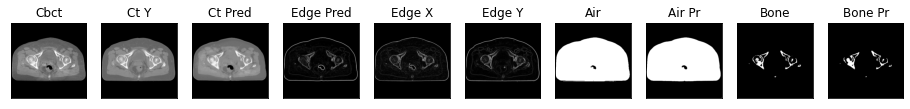

176it [01:42,  1.96it/s]

ssim score = 0.8502197861671448
psnr score = 24.451129913330078
snr score = 15.23626708984375
mae error = 0.024275120347738266
air dice score = 0.9953251959766651
bone dice score = 0.8743047830946551
contour dice score = 0.4642690420150757


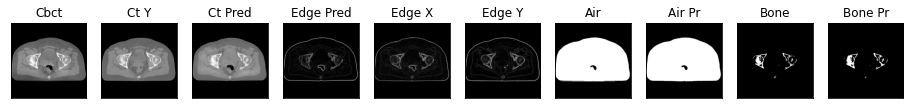

177it [01:43,  1.95it/s]

ssim score = 0.8542530536651611
psnr score = 24.404071807861328
snr score = 15.162084579467773
mae error = 0.024809399619698524
air dice score = 0.9957042957042987
bone dice score = 0.8923388457662447
contour dice score = 0.48899081349372864


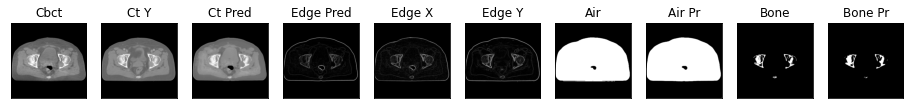

178it [01:43,  1.94it/s]

ssim score = 0.8566521406173706
psnr score = 24.82437515258789
snr score = 15.574383735656738
mae error = 0.025000477209687233
air dice score = 0.9958183863641218
bone dice score = 0.9019736842121386
contour dice score = 0.4644859731197357


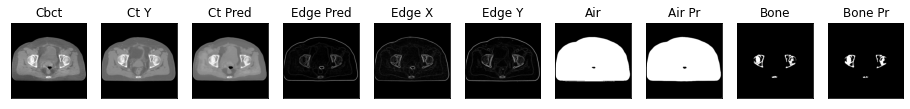

179it [01:44,  1.92it/s]

ssim score = 0.8590938448905945
psnr score = 25.628150939941406
snr score = 16.41238784790039
mae error = 0.023154066875576973
air dice score = 0.9962269973070045
bone dice score = 0.9135344160879577
contour dice score = 0.4686468541622162


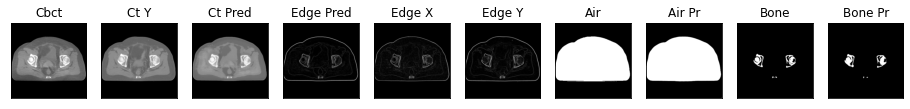

180it [01:44,  1.93it/s]

ssim score = 0.8554758429527283
psnr score = 25.31587791442871
snr score = 16.151607513427734
mae error = 0.02372441068291664
air dice score = 0.9967771799280283
bone dice score = 0.9338829871581753
contour dice score = 0.5072184801101685


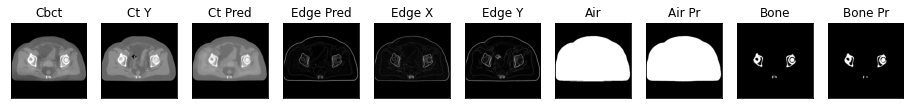

181it [01:45,  1.65it/s]

ssim score = 0.8431262373924255
psnr score = 24.444683074951172
snr score = 15.317972183227539
mae error = 0.025563547387719154
air dice score = 0.9969828151646354
bone dice score = 0.9269787234054983
contour dice score = 0.4951644241809845


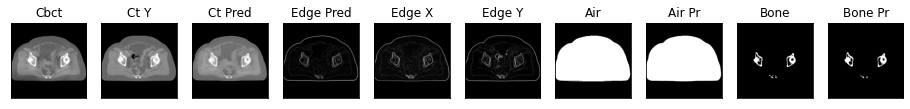

182it [01:46,  1.70it/s]

ssim score = 0.8247256278991699
psnr score = 22.83758544921875
snr score = 13.638437271118164
mae error = 0.029801517724990845
air dice score = 0.9964992087252622
bone dice score = 0.879375790808111
contour dice score = 0.4669603407382965


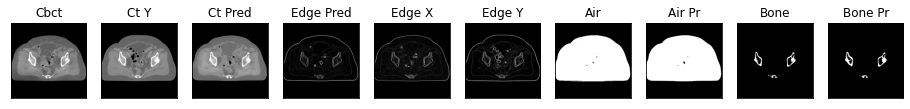

183it [01:46,  1.76it/s]

ssim score = 0.8151313662528992
psnr score = 22.43716049194336
snr score = 13.220016479492188
mae error = 0.03224528580904007
air dice score = 0.9964897452850147
bone dice score = 0.9060125895397002
contour dice score = 0.4616905450820923


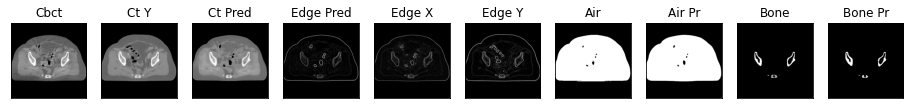

184it [01:47,  1.81it/s]

ssim score = 0.8128745555877686
psnr score = 22.931554794311523
snr score = 13.779325485229492
mae error = 0.031831786036491394
air dice score = 0.9965128122112301
bone dice score = 0.899433130382124
contour dice score = 0.42115670442581177


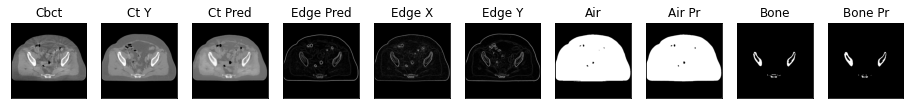

185it [01:47,  1.84it/s]

ssim score = 0.8121495842933655
psnr score = 23.061790466308594
snr score = 13.964656829833984
mae error = 0.031374718993902206
air dice score = 0.9962022946698429
bone dice score = 0.9089590134220356
contour dice score = 0.42330676317214966


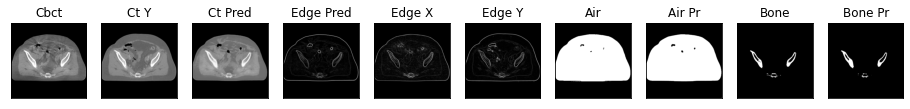

186it [01:48,  1.89it/s]

ssim score = 0.8084045052528381
psnr score = 22.466171264648438
snr score = 13.433466911315918
mae error = 0.0328386127948761
air dice score = 0.9964978715797999
bone dice score = 0.9043478260884158
contour dice score = 0.3972468078136444


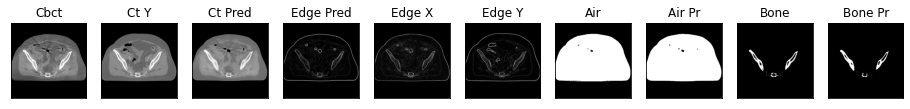

187it [01:48,  1.92it/s]

ssim score = 0.8054720163345337
psnr score = 22.33431625366211
snr score = 13.374467849731445
mae error = 0.03315185382962227
air dice score = 0.9963939702453306
bone dice score = 0.8838197789758597
contour dice score = 0.3494570553302765


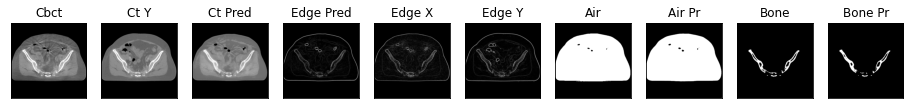

188it [01:49,  1.94it/s]

ssim score = 0.8058278560638428
psnr score = 22.264026641845703
snr score = 13.29988956451416
mae error = 0.03374047204852104
air dice score = 0.9958168265221045
bone dice score = 0.8703145196054817
contour dice score = 0.3595505654811859


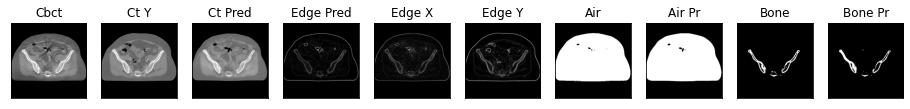

189it [01:49,  1.96it/s]

ssim score = 0.8079490661621094
psnr score = 22.394245147705078
snr score = 13.407931327819824
mae error = 0.03354921564459801
air dice score = 0.9963738192329554
bone dice score = 0.8801760902478997
contour dice score = 0.3333333432674408


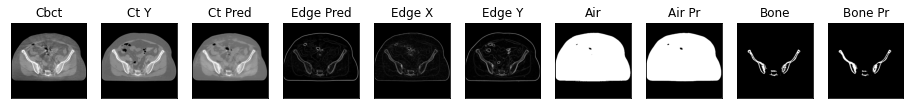

190it [01:50,  1.95it/s]

ssim score = 0.8127418756484985
psnr score = 22.906749725341797
snr score = 13.932069778442383
mae error = 0.032330598682165146
air dice score = 0.9965789557822063
bone dice score = 0.8901651112722159
contour dice score = 0.3323671519756317


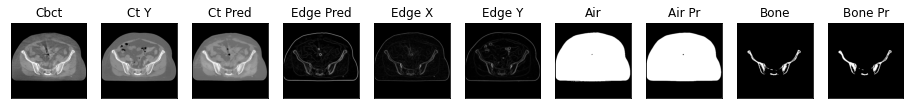

191it [01:51,  1.71it/s]


In [45]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [46]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [47]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [48]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:32,  5.92it/s]


(0.8317067298589577,
 23.29013398055631,
 14.29440590224341,
 0.027280648965486057,
 0.9970629886853594,
 0.8660575814199762,
 0.4875266294516818,
 0.4952879581151832,
 0.4979057591623037)

In [49]:
# import torchvision.models as models
# models.vgg16(pretrained=True)